In [ ]:
import os
import sys

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.probability import FreqDist
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import END_OF_POST_TOKEN, PATH_INTERIM_CORPUS  # noqa: E402

In [2]:
CORPUS_KIND = "xml"
CORPUS_NAME = "depression"

## Genero DataFrames para los corpus de entrenamiento y testeo

In [3]:
input_file_path_train = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-train-clean.txt"
)
input_file_path_test = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-test-clean.txt"
)

In [4]:
labels = []
documents = []
with open(input_file_path_train) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_train = pd.DataFrame({"label": labels, "posts": documents})

In [5]:
labels = []
documents = []
with open(input_file_path_test) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_test = pd.DataFrame({"label": labels, "posts": documents})

## Defino funciones para obtener caracteristicas interesantes de los documentos

En lugar de utilizar una iteracion por las filas del DataFrame aplico una función a todas las filas en paralelo con el método `apply`. Es mucho mas eficiente.

In [6]:
# def get_atributes(post):
#     num_tokens = 0
#     num_tokens_primera_persona = 0
#     for token in post.split():
#         num_tokens += 1
#         if token == 'i':
#             num_tokens_primera_persona += 1
#     return num_tokens, num_tokens_primera_persona

In [7]:
TextBlob(df_test.posts[0][0]).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [8]:
def get_num_tokens(posts_list):
    return [len(post.split()) for post in posts_list]


def get_num_tokens_primera_persona(posts_list):
    return [
        sum(1 if word == "i" else 0 for word in post.split()) for post in posts_list
    ]


def get_polarity(posts_list):
    return [round(TextBlob(post).sentiment.polarity, 2) for post in posts_list]


def get_subjectivity(posts_list):
    return [round(TextBlob(post).sentiment.subjectivity, 2) for post in posts_list]

Otra forma de realizar lo mismo es utilizar una única función que genere mas de una columna. El codigo de la misma es mas complicado y en realidad es mas lento (como se demuestra debajo). Por ello utilizamos las funciones de arriba. En caso de que en lugar de ser dos atributos sean mas, quizas convenga este método que junto todo en una única función que recorre el DataFrame. Vemos que para cuatro atributos son iguales. Optamos por la primera que es mas clara.

In [9]:
def funcion_para_comparar_tiempos():
    df_train.posts.apply(get_num_tokens)
    df_train.posts.apply(get_num_tokens_primera_persona)
    df_train.posts.apply(get_polarity)
    df_train.posts.apply(get_subjectivity)

In [10]:
%timeit funcion_para_comparar_tiempos()

3min 23s ± 9.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def get_atributes(df):
    num_tokens = [len(post.split()) for post in df.posts]
    num_tokens_primera_persona = [
        sum(1 if word == "i" else 0 for word in post.split()) for post in df.posts
    ]
    polarity = [TextBlob(post).sentiment.polarity for post in df.posts]
    subjectivity = [TextBlob(post).sentiment.subjectivity for post in df.posts]
    return [num_tokens, num_tokens_primera_persona, polarity, subjectivity]

In [12]:
%timeit df_train[["posts"]].apply(func=get_atributes, axis=1, result_type='expand')

3min 25s ± 3.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Aplico las funciones al corpus de entrenamiento

In [13]:
# col_tokens = []
# col_primeras_personas = []
# for i, user in df_train.iterrows():
#     n_tokens = []
#     n_primeras_personas = []
#     for post in user.posts:
#         num_tokens, num_tokens_primera_persona = get_atributes(post)
#         n_tokens.append(num_tokens)
#         n_primeras_personas.append(num_tokens_primera_persona)
#     col_tokens.append(n_tokens)
#     col_primeras_personas.append(n_primeras_personas)

In [14]:
# df_train["num_tokens"] = col_tokens
# df_train["num_tokens_primera_persona"] = col_primeras_personas

df_train["num_tokens"] = df_train.posts.apply(get_num_tokens)
df_train["num_tokens_primera_persona"] = df_train.posts.apply(
    get_num_tokens_primera_persona
)
df_train["polarity"] = df_train.posts.apply(get_polarity)
df_train["subjectivity"] = df_train.posts.apply(get_subjectivity)

In [15]:
df_train

label                                              posts  \
0    positive  [also don't give up on the meds try some more ...   
1    positive  [jolteon, vet tech here personal experience th...   
2    positive  [question will a cable that goes from my amp p...   
3    positive  [do you prefer owning cats or dogs why, justin...   
4    positive  [you made it through high school community col...   
..        ...                                                ...   
882  negative  [number award winning pancake recipes that wil...   
883  negative  [warm buttered lobster roll from row number in...   
884  negative  [i'm gonna cheat and say number weblink weblin...   
885  negative  [i dream of being able of turning my house int...   
886  negative  [i think someone is stalking me please help pa...   

                                            num_tokens  \
0    [54, 60, 32, 75, 147, 466, 62, 44, 215, 63, 13...   
1    [1, 86, 8, 7, 5, 517, 39, 5, 6, 42, 9, 66, 14,...   
2    [41, 11, 11, 88, 11, 51, 4, 9, 8, 1, 8, 49, 16...   
3    [8, 2, 8, 4, 2, 7, 1, 2, 5, 9, 23, 20, 2, 19, ...   
4    [13, 20, 8, 62, 1, 13, 11, 1, 5, 5, 25, 30, 7,...   
..                                                 ...   
882  [12, 1, 10, 1, 50, 8, 91, 50, 76, 54, 13, 4, 8...   
883  [9, 10, 5, 28, 8, 8, 21, 26, 2, 8, 5, 9, 7, 18...   
884  [23, 10, 11, 15, 5, 2, 14, 2, 9, 13, 14, 7, 48...   
885  [26, 5, 4, 7, 14, 10, 5, 75, 5, 14, 75, 7, 35,...   
886    [1843, 939, 20, 20, 10, 15, 15, 12, 1027, 1508]   

                            num_tokens_primera_persona  \
0    [0, 5, 3, 7, 14, 25, 4, 4, 17, 7, 12, 11, 4, 8...   
1    [0, 0, 0, 0, 0, 12, 0, 0, 0, 1, 0, 5, 1, 0, 1,...   
2    [3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 7, 2, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
4    [0, 0, 0, 6, 0, 1, 1, 0, 1, 1, 4, 2, 0, 2, 0, ...   
..                                                 ...   
882  [0, 0, 0, 0, 2, 0, 3, 1, 4, 0, 0, 0, 0, 0, 1, ...   
883  [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...   
884  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...   
885  [1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 2, 3, 9, ...   
886                [113, 64, 2, 1, 0, 1, 1, 2, 60, 67]   

                                              polarity  \
0    [-0.1, -0.01, 0.07, 0.08, -0.0, -0.02, 0.06, 0...   
1    [0.0, 0.21, 0.0, 0.43, 0.0, 0.03, 0.05, 0.27, ...   
2    [0.34, -0.3, 0.05, -0.01, 0.1, 0.4, 0.0, 0.0, ...   
3    [0.0, 0.0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4    [0.19, 0.2, 0.0, 0.23, -0.5, 0.0, 0.25, 0.1, 0...   
..                                                 ...   
882  [0.5, 0.0, 0.0, 0.0, 0.35, 0.5, 0.25, -0.01, 0...   
883  [0.6, 0.4, 0.1, 0.25, 0.0, -0.09, 0.1, 0.2, -0...   
884  [0.75, -0.24, 0.0, -0.25, 0.0, 0.0, 0.0, -0.2,...   
885  [0.35, 0.0, 0.0, 0.0, 0.25, 0.06, 0.04, 0.11, ...   
886  [0.05, 0.08, -0.05, 0.8, 0.0, 0.0, -0.12, -0.2...   

                                          subjectivity  
0    [0.41, 0.5, 0.36, 0.44, 0.5, 0.48, 0.68, 0.55,...  
1    [0.0, 0.54, 0.0, 0.73, 0.0, 0.32, 0.68, 0.28, ...  
2    [0.45, 0.2, 0.75, 0.43, 0.2, 0.8, 0.0, 0.0, 0....  
3    [0.0, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4    [0.59, 0.45, 0.0, 0.42, 0.7, 0.0, 0.8, 1.0, 0....  
..                                                 ...  
882  [0.75, 0.0, 0.0, 0.0, 0.39, 1.0, 0.34, 0.29, 0...  
883  [0.6, 0.9, 0.5, 1.0, 0.0, 0.31, 0.47, 0.48, 1....  
884  [0.75, 0.73, 0.0, 0.3, 0.0, 0.0, 0.0, 0.4, 0.0...  
885  [0.41, 0.0, 0.7, 0.4, 1.0, 0.88, 0.62, 0.42, 0...  
886  [0.45, 0.57, 0.4, 0.75, 0.0, 0.07, 0.62, 0.3, ...  

[887 rows x 6 columns]

## Aplico las funciones al corpus de testeo

In [16]:
df_test["num_tokens"] = df_test.posts.apply(get_num_tokens)
df_test["num_tokens_primera_persona"] = df_test.posts.apply(
    get_num_tokens_primera_persona
)
df_test["polarity"] = df_test.posts.apply(get_polarity)
df_test["subjectivity"] = df_test.posts.apply(get_subjectivity)

In [17]:
df_test

label                                              posts  \
0    positive  [because it was me, that guy on the right look...   
1    positive  [it's like an amazing super power amazingly sa...   
2    positive  [my main power animal is the red belly black s...   
3    positive  [empty, this bikini looks great tell me where ...   
4    positive  [have you tried starting it with the help of a...   
..        ...                                                ...   
815  negative  [i ate a tenderloin with chips and onionrings,...   
816  negative  [love this too on his website when you read ab...   
817  negative  [a reporter was arrested for asking secretary ...   
818  negative  [it definitely tasted quite fatty and buttery,...   
819  negative  [johnny depp a star in crisis and the insane s...   

                                            num_tokens  \
0    [4, 7, 25, 235, 27, 44, 39, 4, 131, 61, 12, 5,...   
1    [12, 31, 12, 6, 75, 34, 3, 17, 1, 7, 5, 20, 54...   
2    [64, 6, 28, 25, 106, 32, 40, 27, 107, 71, 8, 1...   
3    [1, 12, 39, 17, 11, 6, 13, 28, 9, 52, 6, 5, 34...   
4    [37, 37, 54, 15, 8, 9, 8, 135, 31, 3, 6, 110, ...   
..                                                 ...   
815  [8, 8, 13, 29, 10, 6, 16, 22, 5, 4, 14, 6, 19,...   
816  [38, 17, 3, 14, 15, 134, 4, 2, 11, 28, 11, 5, ...   
817  [11, 68, 10, 103, 61, 18, 12, 13, 5, 9, 23, 27...   
818  [7, 5, 12, 41, 34, 64, 9, 23, 33, 24, 63, 60, ...   
819  [14, 196, 98, 12, 101, 13, 101, 52, 175, 208, ...   

                            num_tokens_primera_persona  \
0    [0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, ...   
1    [0, 2, 1, 0, 4, 1, 0, 0, 0, 1, 0, 1, 4, 0, 1, ...   
2    [2, 0, 0, 1, 2, 0, 3, 1, 2, 5, 0, 5, 0, 0, 1, ...   
3    [0, 1, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 3, 7, ...   
..                                                 ...   
815  [1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, ...   
816  [1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...   
817  [0, 3, 0, 3, 0, 0, 2, 1, 1, 0, 2, 0, 0, 5, 1, ...   
818  [0, 1, 1, 0, 0, 3, 0, 1, 2, 1, 1, 3, 2, 0, 1, ...   
819  [0, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 4, 0, 0, 0, ...   

                                              polarity  \
0    [0.0, 0.64, 0.05, 0.14, 0.0, 0.0, 0.15, 0.0, 0...   
1    [0.19, -0.16, 0.0, 0.7, 0.03, 0.27, -0.1, 0.0,...   
2    [-0.0, 0.0, 0.0, 0.0, 0.01, 0.59, -0.03, -0.1,...   
3    [-0.1, 0.8, -0.2, 0.7, 0.35, 0.0, 0.1, 0.31, -...   
4    [0.0, 0.05, 0.08, 0.32, 0.0, 0.0, 0.1, 0.3, 0....   
..                                                 ...   
815  [0.0, -0.13, 0.3, -0.02, -0.32, 0.0, 0.0, 0.32...   
816  [0.08, 0.0, 0.2, 0.6, 0.32, 0.03, 0.6, 0.7, 0....   
817  [0.0, 0.26, 0.15, 0.22, 0.13, 0.02, 0.2, 0.12,...   
818  [-0.1, 0.0, 0.0, 0.03, -0.12, -0.08, -0.4, 0.0...   
819  [-0.6, 0.22, 0.13, 0.45, 0.43, 0.14, -0.13, -0...   

                                          subjectivity  
0    [0.0, 0.77, 0.57, 0.37, 0.0, 0.0, 0.41, 0.0, 0...  
1    [0.81, 0.39, 0.0, 0.6, 0.4, 0.42, 0.0, 0.5, 0....  
2    [0.31, 0.0, 0.43, 0.05, 0.45, 0.78, 0.03, 0.51...  
3    [0.5, 0.75, 0.44, 0.6, 0.35, 0.0, 0.4, 0.38, 0...  
4    [0.23, 0.61, 0.15, 0.48, 0.0, 0.0, 1.0, 0.52, ...  
..                                                 ...  
815  [0.0, 0.5, 0.45, 0.69, 0.47, 0.0, 0.0, 0.48, 0...  
816  [0.45, 0.0, 0.2, 0.92, 0.48, 0.32, 1.0, 0.6, 0...  
817  [0.0, 0.61, 0.83, 0.51, 0.73, 0.24, 0.4, 0.47,...  
818  [0.45, 0.0, 0.62, 0.32, 0.38, 0.35, 0.6, 0.26,...  
819  [0.53, 0.62, 0.43, 0.4, 0.67, 0.27, 0.61, 0.47...  

[820 rows x 6 columns]

## Genero algunas gráficas para comparar ambos corpus

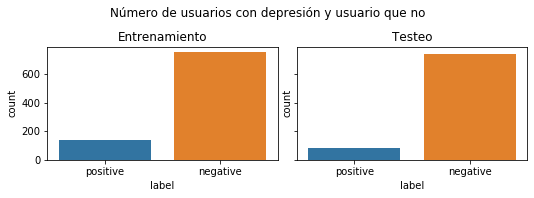

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 3))
ax1.set_title("Entrenamiento")
ax2.set_title("Testeo")
fig.suptitle("Número de usuarios con depresión y usuario que no")
sns.countplot(x="label", data=df_train, ax=ax1)
sns.countplot(x="label", data=df_test, ax=ax2)
plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

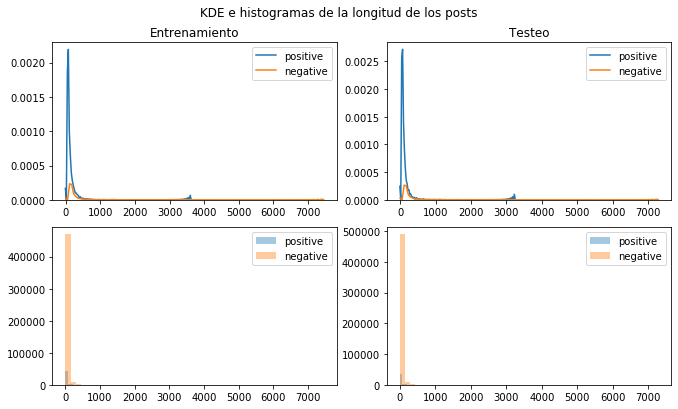

In [19]:
num_tokens_train = df_train.groupby("label").agg({"num_tokens": sum})
num_tokens_train = num_tokens_train.num_tokens.apply(lambda x: np.array(x))
num_tokens_train.apply(lambda x: x.sort())

num_tokens_test = df_test.groupby("label").agg({"num_tokens": sum})
num_tokens_test = num_tokens_test.num_tokens.apply(lambda x: np.array(x))
num_tokens_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))

axis[0, 0].set_title("Entrenamiento")
axis[0, 1].set_title("Testeo")
fig.suptitle("KDE e histogramas de la longitud de los posts")

sns.kdeplot(num_tokens_train["positive"], ax=axis[0, 0], label="positive")
sns.kdeplot(num_tokens_train["negative"], ax=axis[0, 0], label="negative")

sns.kdeplot(num_tokens_test["positive"], ax=axis[0, 1], label="positive")
sns.kdeplot(num_tokens_test["negative"], ax=axis[0, 1], label="negative")

sns.distplot(num_tokens_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.distplot(num_tokens_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.distplot(num_tokens_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.distplot(num_tokens_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

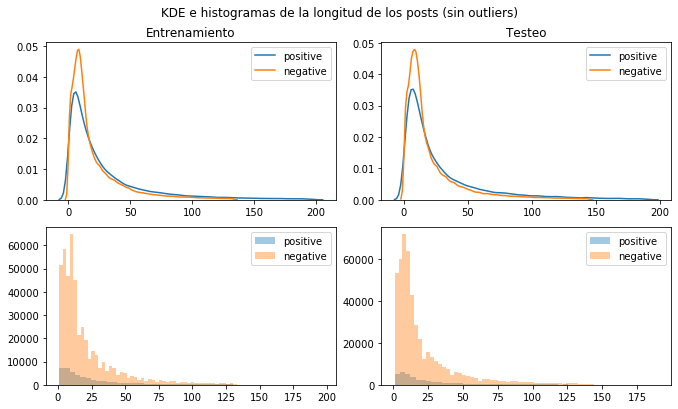

In [20]:
outlier_train_negative, outlier_train_positive = (
    np.quantile(num_tokens_train[0], 0.97),
    np.quantile(num_tokens_train[1], 0.97),
)
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_tokens_test[0], 0.97),
    np.quantile(num_tokens_test[1], 0.97),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Entrenamiento")
axis[0, 1].set_title("Testeo")
fig.suptitle("KDE e histogramas de la longitud de los posts (sin outliers)")

without_outliers = num_tokens_train["positive"][
    num_tokens_train["positive"] < outlier_train_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="positive")
sns.distplot(without_outliers, ax=axis[1, 0], label="positive", kde=False)

without_outliers = num_tokens_train["negative"][
    num_tokens_train["negative"] < outlier_train_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="negative")
sns.distplot(without_outliers, ax=axis[1, 0], label="negative", kde=False)

without_outliers = num_tokens_test["positive"][
    num_tokens_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_tokens_test["negative"][
    num_tokens_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

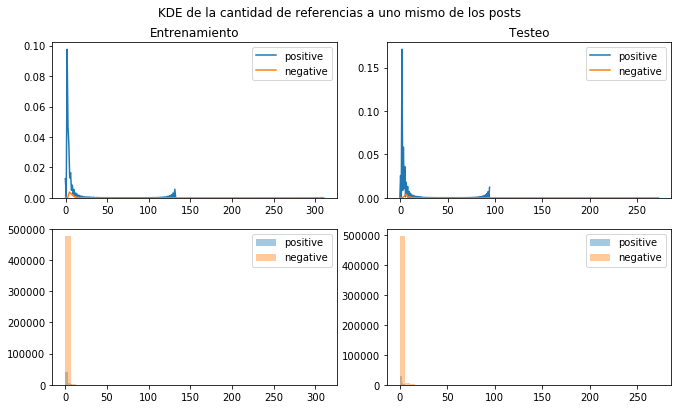

In [21]:
num_yo_train = df_train.groupby("label").agg({"num_tokens_primera_persona": sum})
num_yo_train = num_yo_train.num_tokens_primera_persona.apply(lambda x: np.array(x))
num_yo_train.apply(lambda x: x.sort())

num_yo_test = df_test.groupby("label").agg({"num_tokens_primera_persona": sum})
num_yo_test = num_yo_test.num_tokens_primera_persona.apply(lambda x: np.array(x))
num_yo_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Entrenamiento")
axis[0, 1].set_title("Testeo")
fig.suptitle("KDE de la cantidad de referencias a uno mismo de los posts")

sns.kdeplot(num_yo_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(num_yo_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(num_yo_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(num_yo_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(num_yo_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(num_yo_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(num_yo_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(num_yo_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

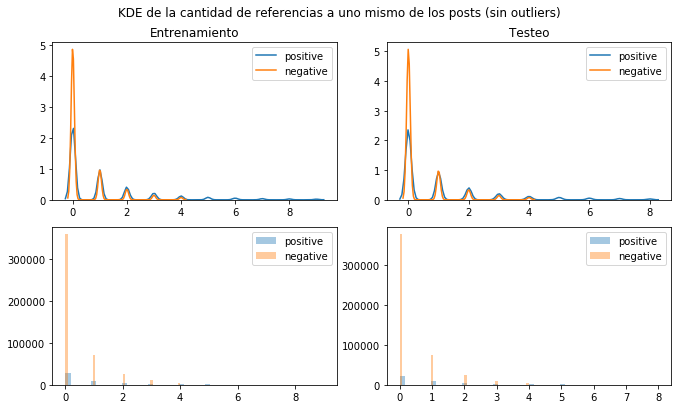

In [22]:
outlier_threshold = 0.98
outlier_train_negative, outlier_train_positive = (
    np.quantile(num_yo_train[0], outlier_threshold),
    np.quantile(num_yo_train[1], outlier_threshold),
)
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_yo_test[0], outlier_threshold),
    np.quantile(num_yo_test[1], outlier_threshold),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Entrenamiento")
axis[0, 1].set_title("Testeo")
fig.suptitle(
    "KDE de la cantidad de referencias a uno mismo de los posts (sin outliers)"
)

without_outliers = num_yo_train["positive"][
    num_yo_train["positive"] < outlier_train_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="positive")
sns.distplot(without_outliers, ax=axis[1, 0], label="positive", kde=False)

without_outliers = num_yo_train["negative"][
    num_yo_train["negative"] < outlier_train_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="negative")
sns.distplot(without_outliers, ax=axis[1, 0], label="negative", kde=False)

without_outliers = num_yo_test["positive"][
    num_yo_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_yo_test["negative"][
    num_yo_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

## Latent Dirichlet Allocation (LDA)
Aplico LDA para obtener los tópicos más relevantes tanto de documentos de personas positivas como de personas negativas para depresión, tanto para entrenamiento y para testeo.

### LDA de scikit-learn

In [23]:
n_components = 10
max_features = 20_000
max_df = 0.05
num_words_to_show = 15

### Documentos del corpus de entrenamiento que son de usuarios depresivos

In [24]:
vect_pos_train = CountVectorizer(max_features=max_features, max_df=max_df)
X_pos_train = vect_pos_train.fit_transform(
    df_train[df_train.label == "positive"].posts.sum()
)

In [25]:
lda_pos_train = LatentDirichletAllocation(
    n_components=n_components, learning_method="batch", max_iter=20, random_state=0
)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
topicos_doc_pos_train = lda_pos_train.fit_transform(X_pos_train)

In [26]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_pos_train = np.argsort(lda_pos_train.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names_pos_train = np.array(vect_pos_train.get_feature_names())

### Documentos del corpus de entrenamiento que son de usuarios que NO son depresivos

In [27]:
vect_neg_train = CountVectorizer(max_features=max_features, max_df=max_df)
X_neg_train = vect_neg_train.fit_transform(
    df_train[df_train.label == "negative"].posts.sum()
)

In [28]:
lda_neg_train = LatentDirichletAllocation(
    n_components=n_components, learning_method="batch", max_iter=20, random_state=0
)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
topicos_doc_neg_train = lda_neg_train.fit_transform(X_neg_train)

In [29]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_neg_train = np.argsort(lda_neg_train.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names_neg_train = np.array(vect_neg_train.get_feature_names())

### Documentos del corpus de testeo que son de usuarios depresivos

In [30]:
vect_pos_test = CountVectorizer(max_features=max_features, max_df=max_df)
X_pos_test = vect_pos_test.fit_transform(
    df_test[df_test.label == "positive"].posts.sum()
)

In [31]:
lda_pos_test = LatentDirichletAllocation(
    n_components=n_components, learning_method="batch", max_iter=20, random_state=0
)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
topicos_doc_pos_test = lda_pos_test.fit_transform(X_pos_test)

In [32]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_pos_test = np.argsort(lda_pos_test.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names_pos_test = np.array(vect_pos_test.get_feature_names())

### Documentos del corpus de testeo que son de usuarios que NO son depresivos

In [33]:
vect_neg_test = CountVectorizer(max_features=max_features, max_df=max_df)
X_neg_test = vect_neg_test.fit_transform(
    df_test[df_test.label == "negative"].posts.sum()
)

In [34]:
lda_neg_test = LatentDirichletAllocation(
    n_components=n_components, learning_method="batch", max_iter=20, random_state=0
)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
topicos_doc_neg_test = lda_neg_test.fit_transform(X_neg_test)

In [35]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_neg_test = np.argsort(lda_neg_test.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names_neg_test = np.array(vect_neg_test.get_feature_names())

### Mostramos los tópicos encontrados y las palabras más relevantes en cada uno de los corpus

In [36]:
agrupamiento = [
    ("Corpus entrenamiento positivos", sorting_pos_train, feature_names_pos_train),
    ("Corpus entrenamiento negativos", sorting_neg_train, feature_names_neg_train),
    ("Corpus testeo positivos", sorting_pos_test, feature_names_pos_test),
    ("Corpus testeo negativos", sorting_neg_test, feature_names_neg_test),
]

print(f"{num_words_to_show} palabras más relevantes de cada tópico:")
print("-" * 80)
for label, sorting, feature_names in agrupamiento:
    print(label)
    for i in range(n_components):
        words = (feature_names[sorting[i, :]].tolist())[:num_words_to_show]
        words = ", ".join(words)
        print(f"T {i}: {words}")
    print(" -" * 40)

15 palabras más relevantes de cada tópico:
--------------------------------------------------------------------------------
Corpus entrenamiento positivos
T 0: did, black, hair, look, fuck, white, looks, thought, fucking, off, were, little, never, girl, picture
T 1: thank, skin, use, face, using, oil, very, makeup, routine, am, used, season, products, charlie, should
T 2: shit, yeah, pretty, water, use, sure, yes, going, try, right, ll, work, why, put, though
T 3: his, were, most, character, read, book, movie, never, him, story, show, which, world, god, why
T 4: thank, thanks, day, oh, its, ll, haha, sleep, awesome, wow, back, very, yeah, love, cat
T 5: she, her, him, his, am, going, someone, life, things, friends, didn, were, never, years, said
T 6: game, depression, play, take, need, team, life, into, going, better, work, should, first, which, after
T 7: their, why, women, someone, men, doesn, should, say, same, sex, which, person, many, most, does
T 8: money, work, got, day, buy, jo

### Tópicos encontrados para todo el corpus de entrenamiento

In [37]:
vect_train = CountVectorizer(max_features=max_features, max_df=max_df)
X_train = vect_train.fit_transform(df_train.posts.sum())

In [38]:
lda_train = LatentDirichletAllocation(
    n_components=n_components, learning_method="batch", max_iter=20, random_state=0
)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
topicos_doc_train = lda_train.fit_transform(X_train)

In [39]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_train = np.argsort(lda_train.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names_train = np.array(vect_train.get_feature_names())

In [40]:
print(f"{num_words_to_show} palabras más relevantes de cada tópico:")
print("-" * 80)
print("Corpus de entrenamiento entero")
for i in range(n_components):
    words = (feature_names_train[sorting_train[i, :]].tolist())[:num_words_to_show]
    words = ", ".join(words)
    print(f"T {i}: {words}")
print(" -" * 40)

15 palabras más relevantes de cada tópico:
--------------------------------------------------------------------------------
Corpus de entrenamiento entero
T 0: his, into, down, had, off, back, him, car, then, were, over, around, house, could, man
T 1: science, than, study, which, new, could, research, food, water, may, energy, also, ama, use, human
T 2: his, world, book, movie, were, most, show, story, read, who, ever, first, film, books, been
T 3: post, new, reddit, please, here, use, been, link, free, google, any, subreddit, video, does, should
T 4: their, them, than, other, re, any, because, make, which, even, way, only, much, also, who
T 5: she, her, him, who, know, his, why, because, did, someone, re, say, want, didn, fuck
T 6: us, police, war, keys, after, law, were, their, who, government, gun, against, state, military, over
T 7: good, really, love, thanks, great, too, pretty, looks, much, game, awesome, very, yeah, nice, well
T 8: ve, time, had, been, now, go, day, years, got, 

### LDA de gensim

In [41]:
def get_bigrams_model(words, min_count=15):
    """
    Función que retorna el modelo de bigramas de las palabras.
    Esto permite determinar si dos palabras se usan como frase juntas.
    :param words: lista de lista de palabras
    :param min_count: minima cantidad de veces que debe ocurrir el bigrama
                        para ser considerado.
    :return: modelo de bigrama
    """
    bigram = gensim.models.Phrases(words, min_count=min_count)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod


def get_corpus_for_lda(posts, bigram_model=None, id2word=None):
    """
    Función que transforma el corpus para que pueda ser procesado
    por LDA.
    Para usar LDA en el corpus de prueba se pasa el modelo de bigrama y el
    id2word como parámetros.
    :param posts: lista de lista de palabras
    :param bigram_model: modelo de bigrama para transformar el texto. En caso de tener el
                        valor igual a None se genera, en otro caso se utiliza el pasado por
                        parametro.
    :param id2word: diccionario con los distintos bigramas obtenidos para el corpus. En caso
                    de ser None se calcula, en otro caso se utiliza el pasado por parámetro.
    :return: tupla (corpus, id2word, bigram) donde
            corpus es el dataset transformado
            id2word es un diccionario con el valor de cada identificador de palabra
            bigram_model es el modelo de brigrama
    """
    if bigram_model is None:
        bigram_model = get_bigrams_model(posts)
    else:
        bigram_model = bigram_model
    bigrams = [bigram_model[post] for post in posts]

    if id2word is None:
        id2word = gensim.corpora.Dictionary(bigrams)
        id2word.filter_extremes(no_below=10, no_above=0.6)
        id2word.compactify()
    else:
        id2word = id2word
    corpus = [id2word.doc2bow(text) for text in bigrams]
    return corpus, id2word, bigram_model

In [42]:
posts = []
for user_posts in df_train.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts.append(aux_list_posts)

In [43]:
corpus, id2word, bigram = get_corpus_for_lda(posts)

In [44]:
lda_train = gensim.models.LdaModel(
    corpus=corpus,
    num_topics=15,
    id2word=id2word,
    chunksize=100,
    passes=50,
    eval_every=1,
    random_state=30,  # Dejamos fija la semilla de numero aleatorio para reproducibilidad
    per_word_topics=True,
)
# lda_train.save('lda_train.model')

In [45]:
lda_train.print_topics(num_topics=-1, num_words=20)

[(0,
  '0.003*"i\'ve_been" + 0.003*"women" + 0.003*"okay" + 0.003*"depression" + 0.003*"sex" + 0.003*"however" + 0.003*"advice" + 0.003*"she\'s" + 0.003*"relationship" + 0.002*"don\'t_want" + 0.002*"felt" + 0.002*"pain" + 0.002*"sleep" + 0.002*"anyway" + 0.002*"often" + 0.002*"men" + 0.002*"etc" + 0.002*"honestly" + 0.002*"situation" + 0.002*"doctor"'),
 (1,
  '0.000*"labelling" + 0.000*"hobby_lobby" + 0.000*"equate" + 0.000*"airs" + 0.000*"lgbtq" + 0.000*"18m" + 0.000*"emphasis" + 0.000*"hawks" + 0.000*"injected" + 0.000*"pcp" + 0.000*"push_ups" + 0.000*"scorching" + 0.000*"seattle" + 0.000*"yoga" + 0.000*"\'star" + 0.000*"2k15" + 0.000*"2pac" + 0.000*"associates" + 0.000*"emptying" + 0.000*"inconsistencies"'),
 (2,
  '0.011*"im" + 0.011*"dont" + 0.008*"didnt" + 0.007*"door" + 0.007*"thats" + 0.006*"eyes" + 0.005*"cant" + 0.004*"looked" + 0.004*"wasnt" + 0.004*"felt" + 0.004*"id" + 0.003*"floor" + 0.003*"turned" + 0.003*"bed" + 0.003*"dark" + 0.003*"doesnt" + 0.003*"began" + 0.003*"wa

In [46]:
top_topics = lda_train.get_document_topics(corpus[1], minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(10)]
top_topics, topic_vec

([(0, 0.1868723),
  (1, 5.8515838e-05),
  (2, 0.06945546),
  (3, 0.14542744),
  (4, 5.851599e-05),
  (5, 5.8515838e-05),
  (6, 0.055645388),
  (7, 0.001422124),
  (8, 0.047957692),
  (9, 5.8515998e-05),
  (10, 0.01039301),
  (11, 0.019902188),
  (12, 5.8515838e-05),
  (13, 0.46257326),
  (14, 5.8515838e-05)],
 [0.1868723,
  5.8515838e-05,
  0.06945546,
  0.14542744,
  5.851599e-05,
  5.8515838e-05,
  0.055645388,
  0.001422124,
  0.047957692,
  5.8515998e-05])

In [47]:
posts_test = []
for user_posts in df_test.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts_test.append(aux_list_posts)

In [48]:
posts_test[0][:10]

['because', 'it', 'was', 'me', 'that', 'guy', 'on', 'the', 'right', 'looks']

In [49]:
corpus_test, _, _ = get_corpus_for_lda(posts_test, bigram_model=bigram, id2word=id2word)

In [50]:
top_topics_test = lda_train.get_document_topics(corpus_test[1], minimum_probability=0.0)
topic_vec_test = [top_topics_test[i][1] for i in range(10)]
top_topics_test, topic_vec_test

([(0, 0.32026726),
  (1, 5.896136e-05),
  (2, 0.0147631895),
  (3, 0.014230993),
  (4, 0.3213215),
  (5, 5.896136e-05),
  (6, 0.09302395),
  (7, 5.8961465e-05),
  (8, 5.8961523e-05),
  (9, 0.15424511),
  (10, 5.8961483e-05),
  (11, 5.8961523e-05),
  (12, 5.896136e-05),
  (13, 0.08167634),
  (14, 5.896136e-05)],
 [0.32026726,
  5.896136e-05,
  0.0147631895,
  0.014230993,
  0.3213215,
  5.896136e-05,
  0.09302395,
  5.8961465e-05,
  5.8961523e-05,
  0.15424511])

## Gráficos relacionados al Análisis de Sentimiento de los posts de los usuarios

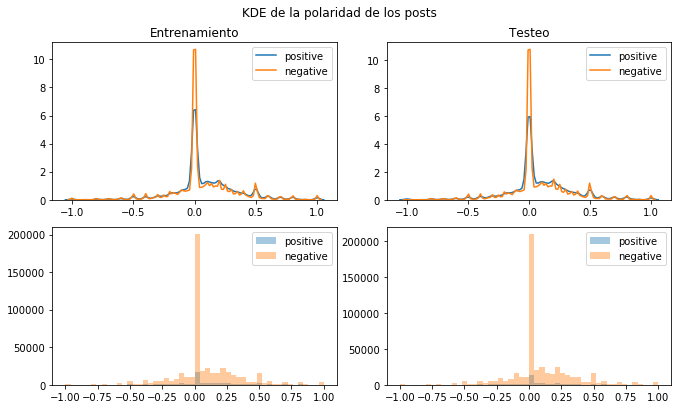

In [51]:
polarity_train = df_train.groupby("label").agg({"polarity": sum})
polarity_train = polarity_train.polarity.apply(lambda x: np.array(x))

polarity_test = df_test.groupby("label").agg({"polarity": sum})
polarity_test = polarity_test.polarity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Entrenamiento")
axis[0, 1].set_title("Testeo")
fig.suptitle("KDE de la polaridad de los posts")

sns.kdeplot(polarity_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(polarity_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(polarity_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(polarity_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(polarity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(polarity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(polarity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(polarity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

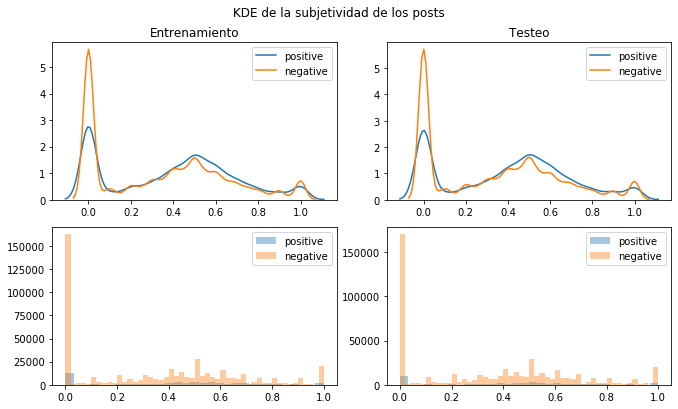

In [52]:
subjectivity_train = df_train.groupby("label").agg({"subjectivity": sum})
subjectivity_train = subjectivity_train.subjectivity.apply(lambda x: np.array(x))

subjectivity_test = df_test.groupby("label").agg({"subjectivity": sum})
subjectivity_test = subjectivity_test.subjectivity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Entrenamiento")
axis[0, 1].set_title("Testeo")
fig.suptitle("KDE de la subjetividad de los posts")

sns.kdeplot(subjectivity_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(subjectivity_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(subjectivity_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(subjectivity_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(subjectivity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(subjectivity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(subjectivity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(subjectivity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

##  Nube de palabras

https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

### Dataset de Entrenamiento

In [53]:
plain_train_posts = [p for _posts in df_train.posts for p in _posts]
plain_test_posts = [p for _posts in df_test.posts for p in _posts]

plain_posts = plain_train_posts + plain_test_posts

In [54]:
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b[\w']+\b", use_idf=True)
vectorizer.fit(plain_posts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern="(?u)\\b[\\w']+\\b",
                tokenizer=None, use_idf=True, vocabulary=None)

In [55]:
idx2word = {idx: word for (word, idx) in vectorizer.vocabulary_.items()}

In [56]:
idf_sort_idxs = np.argsort(vectorizer.idf_)

# Las 10 palabras que mas se repiten en los documentos.
for i in idf_sort_idxs[:10]:
    print(f"'{idx2word[i]}': {vectorizer.idf_[i]}")

'the': 1.8385126580218785
'to': 2.065782105987998
'a': 2.0953878300882067
'and': 2.2483032307449453
'of': 2.26999189610111
'i': 2.313281589240431
'in': 2.4042204741808533
'is': 2.465637878126855
'it': 2.5621901006269847
'that': 2.5639281673770755


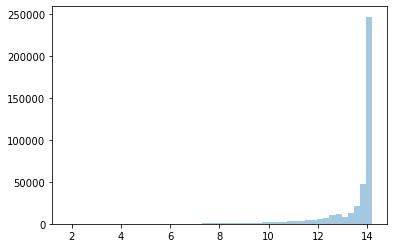

In [57]:
# Distribución de los valores de idf en todo el dataset.
sns.distplot(vectorizer.idf_, kde=False);

In [58]:
min_percentile = 0.1
min_idf_allowed = np.percentile(vectorizer.idf_, min_percentile)

In [59]:
users_posts = df_train.posts
"""allwords = []
for user_posts in users_posts:
    for post in user_posts:
        for word in post.split():
            if word in vectorizer.vocabulary_:
                current_idx = vectorizer.vocabulary_[word]
                if vectorizer.idf_[current_idx] > min_idf_allowed:
                    allwords.append(word)
"""
allwords = [
    word
    for user_posts in users_posts
    for post in user_posts
    for word in post.split()
    if (word in vectorizer.vocabulary_)
    and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
]

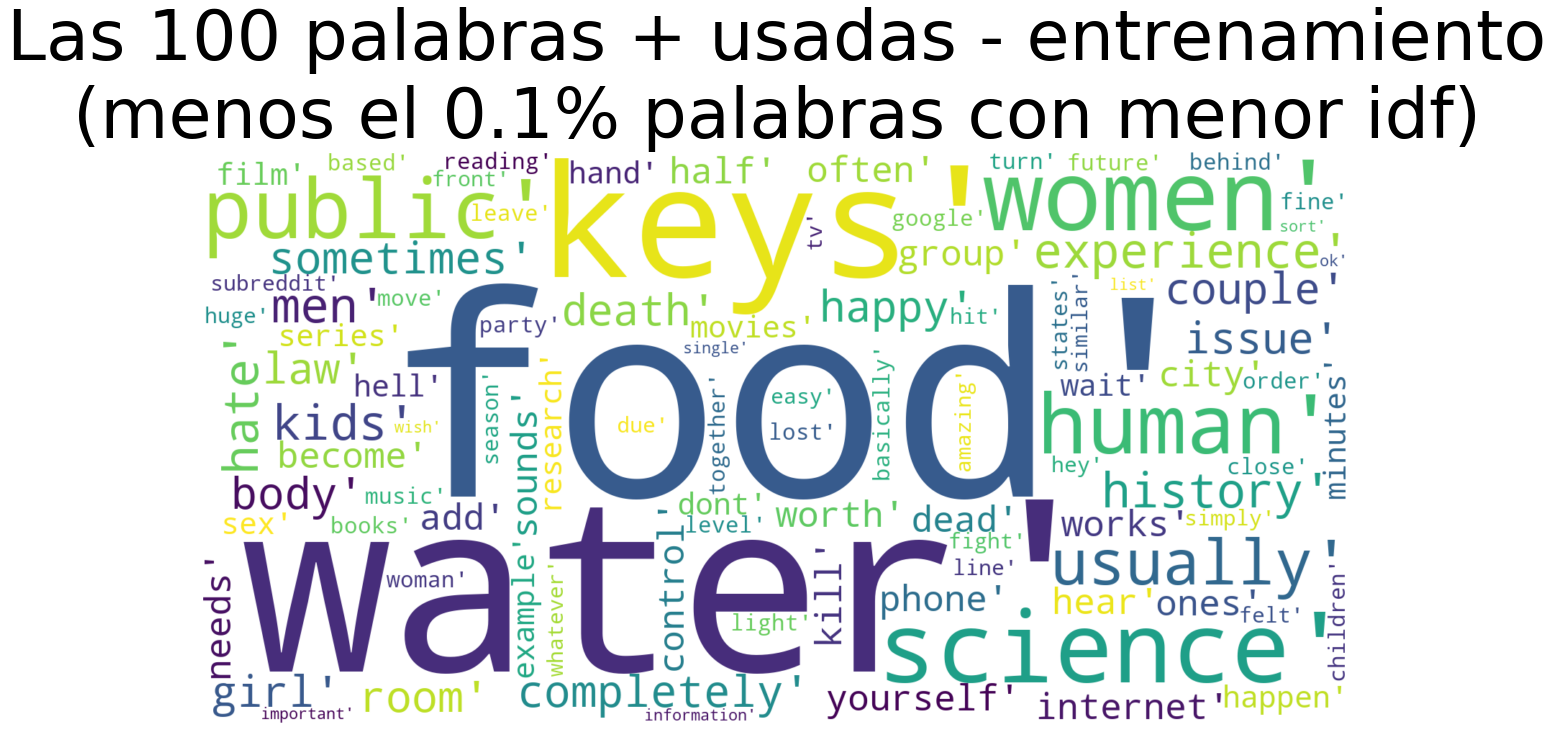

In [60]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    str(mostcommon)
)
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"Las 100 palabras + usadas - entrenamiento\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

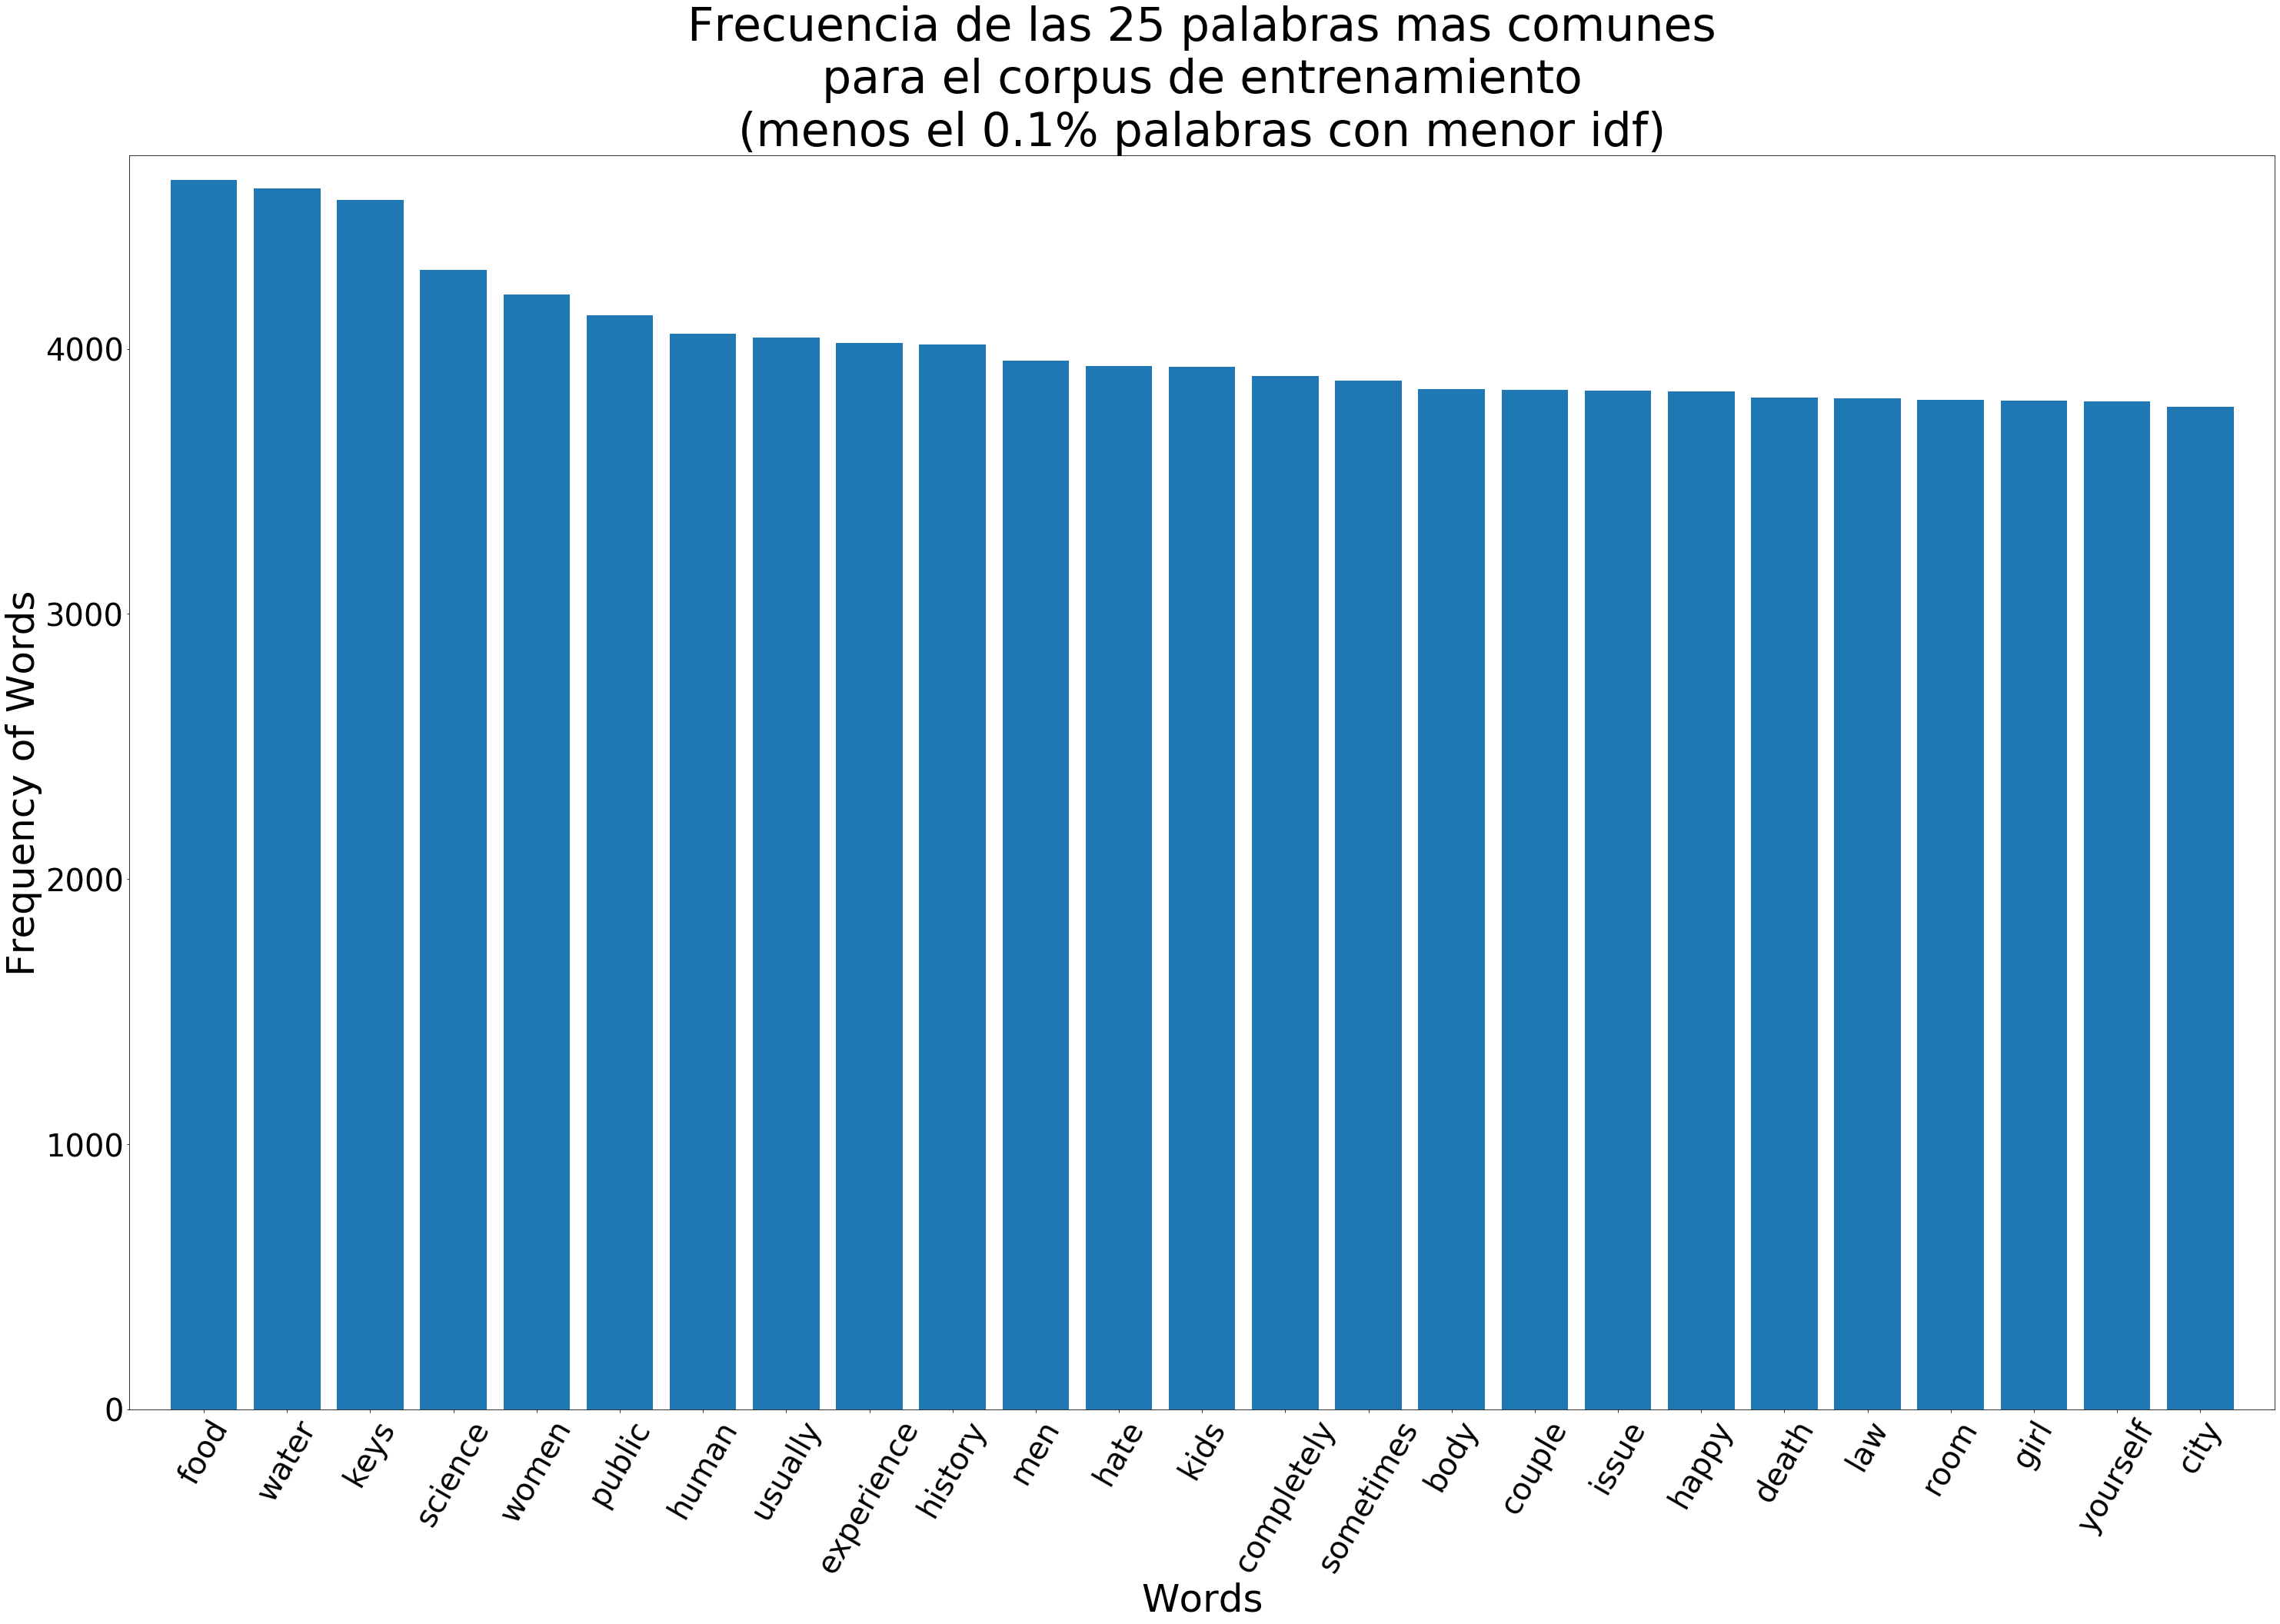

In [61]:
mostcommon_small_training = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small_training)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    f"Frecuencia de las 25 palabras mas comunes\npara el corpus de entrenamiento\n"
    f"(menos el {min_percentile}% palabras con menor idf)",
    fontsize=60,
)
plt.show()

### Nube de palabras para usuarios positivos en el corpus de entrenamiento

In [62]:
positive_users_posts = df_train.posts[df_train.label == "positive"]
"""
positive_allwords = []
for user_posts in positive_users_posts:
    for post in user_posts:
        for word in post.split():
            if word in vectorizer.vocabulary_:
                current_idx = vectorizer.vocabulary_[word]
                if vectorizer.idf_[current_idx] > min_idf_allowed:
                    positive_allwords.append(word)
"""
positive_allwords = [
    word
    for user_posts in positive_users_posts
    for post in user_posts
    for word in post.split()
    if (word in vectorizer.vocabulary_)
    and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
]

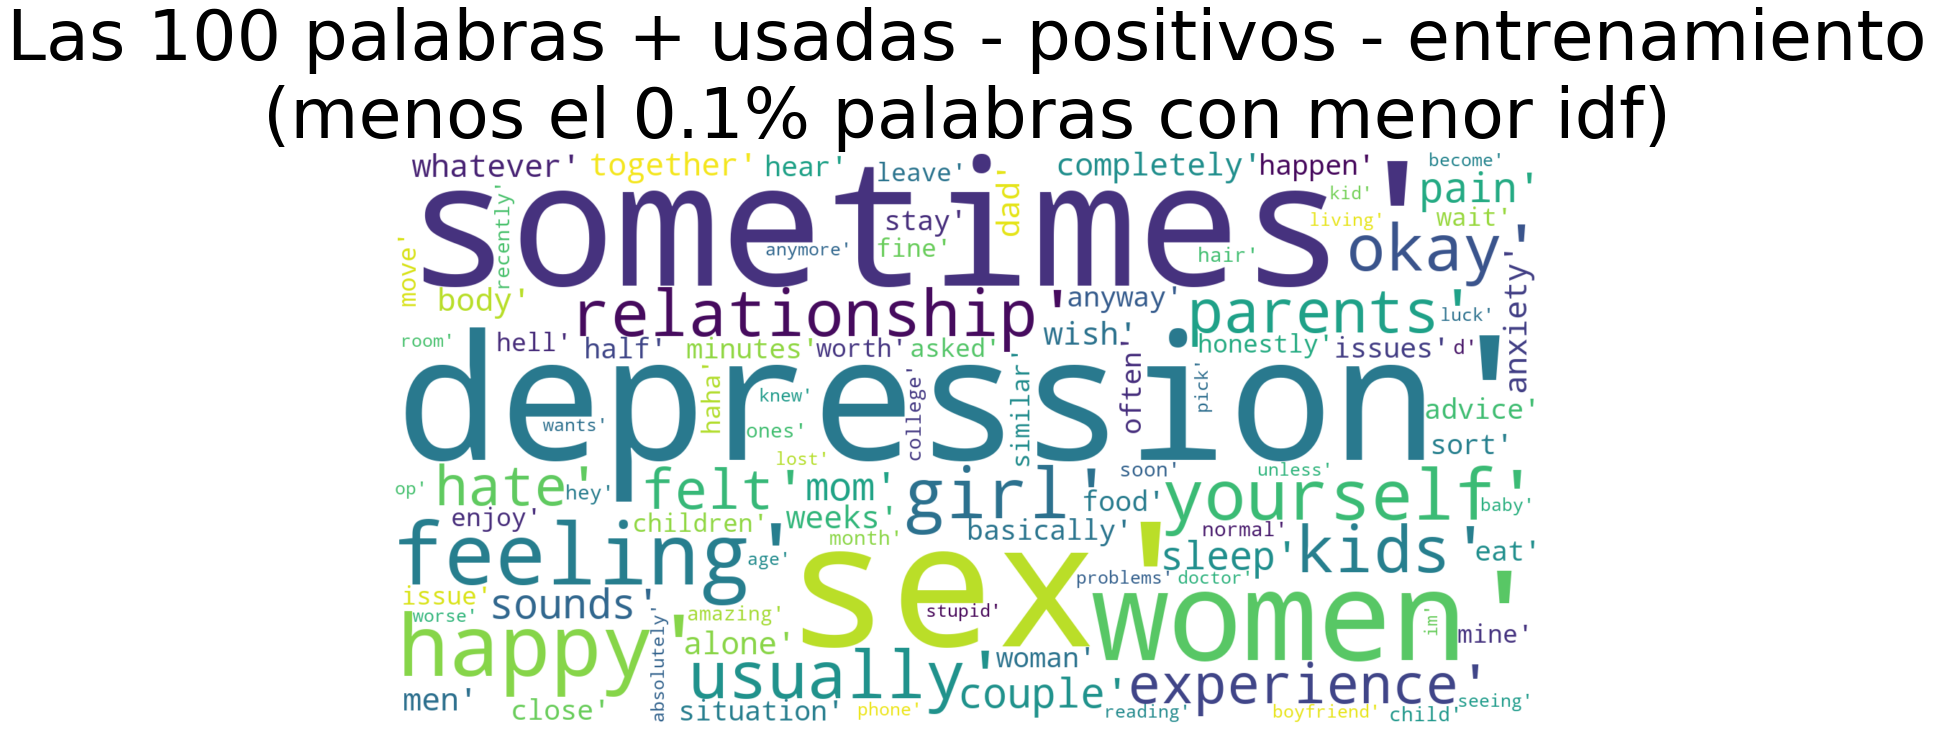

In [63]:
positive_mostcommon = FreqDist(positive_allwords).most_common(100)
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(str(positive_mostcommon))
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"Las 100 palabras + usadas - positivos - entrenamiento\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

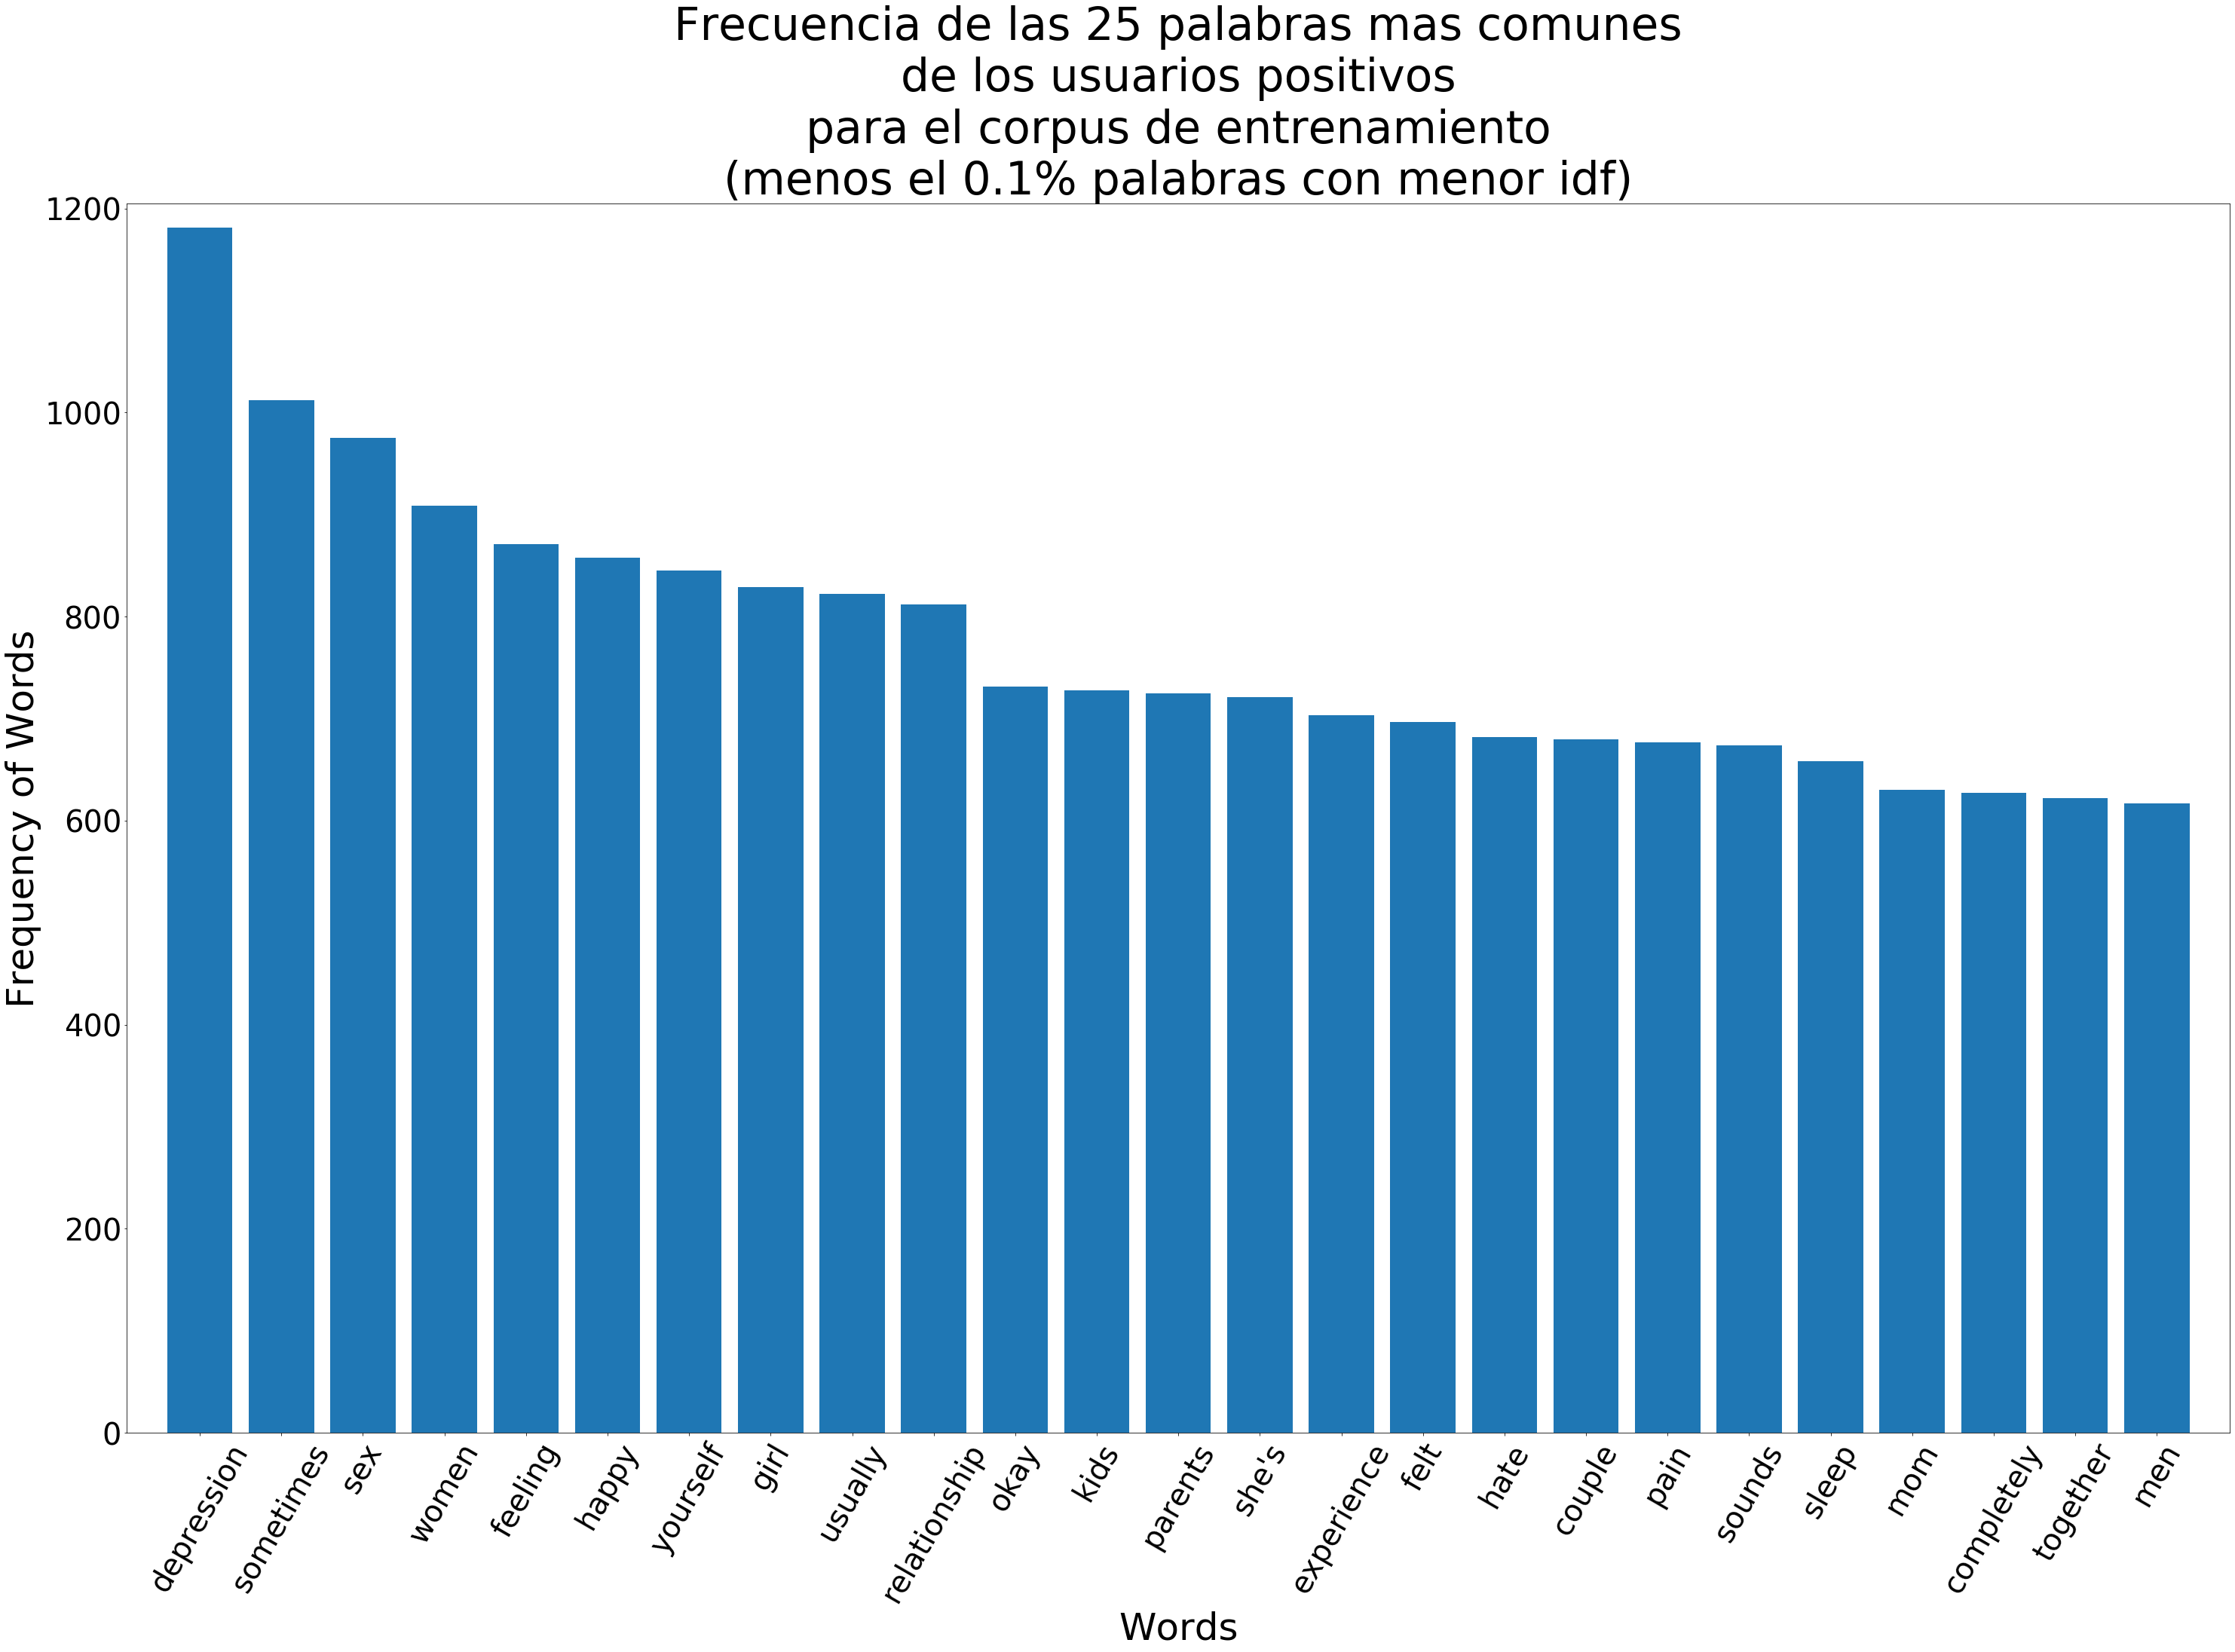

In [64]:
positive_mostcommon_small = FreqDist(positive_allwords).most_common(25)
x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    f"Frecuencia de las 25 palabras mas comunes\nde los usuarios positivos\n"
    f"para el corpus de entrenamiento\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=60,
)
plt.show()

### Nube de palabras para usuarios negativos en el corpus de entrenamiento

In [65]:
negative_users_posts = df_train.posts[df_train.label == "negative"]
negative_allwords = []
"""
for user_posts in negative_users_posts:
    for post in user_posts:
        for word in post.split():
            if word in vectorizer.vocabulary_:
                current_idx = vectorizer.vocabulary_[word]
                if vectorizer.idf_[current_idx] > min_idf_allowed:
                    negative_allwords.append(word)
"""
negative_allwords = [
    word
    for user_posts in negative_users_posts
    for post in user_posts
    for word in post.split()
    if (word in vectorizer.vocabulary_)
    and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
]

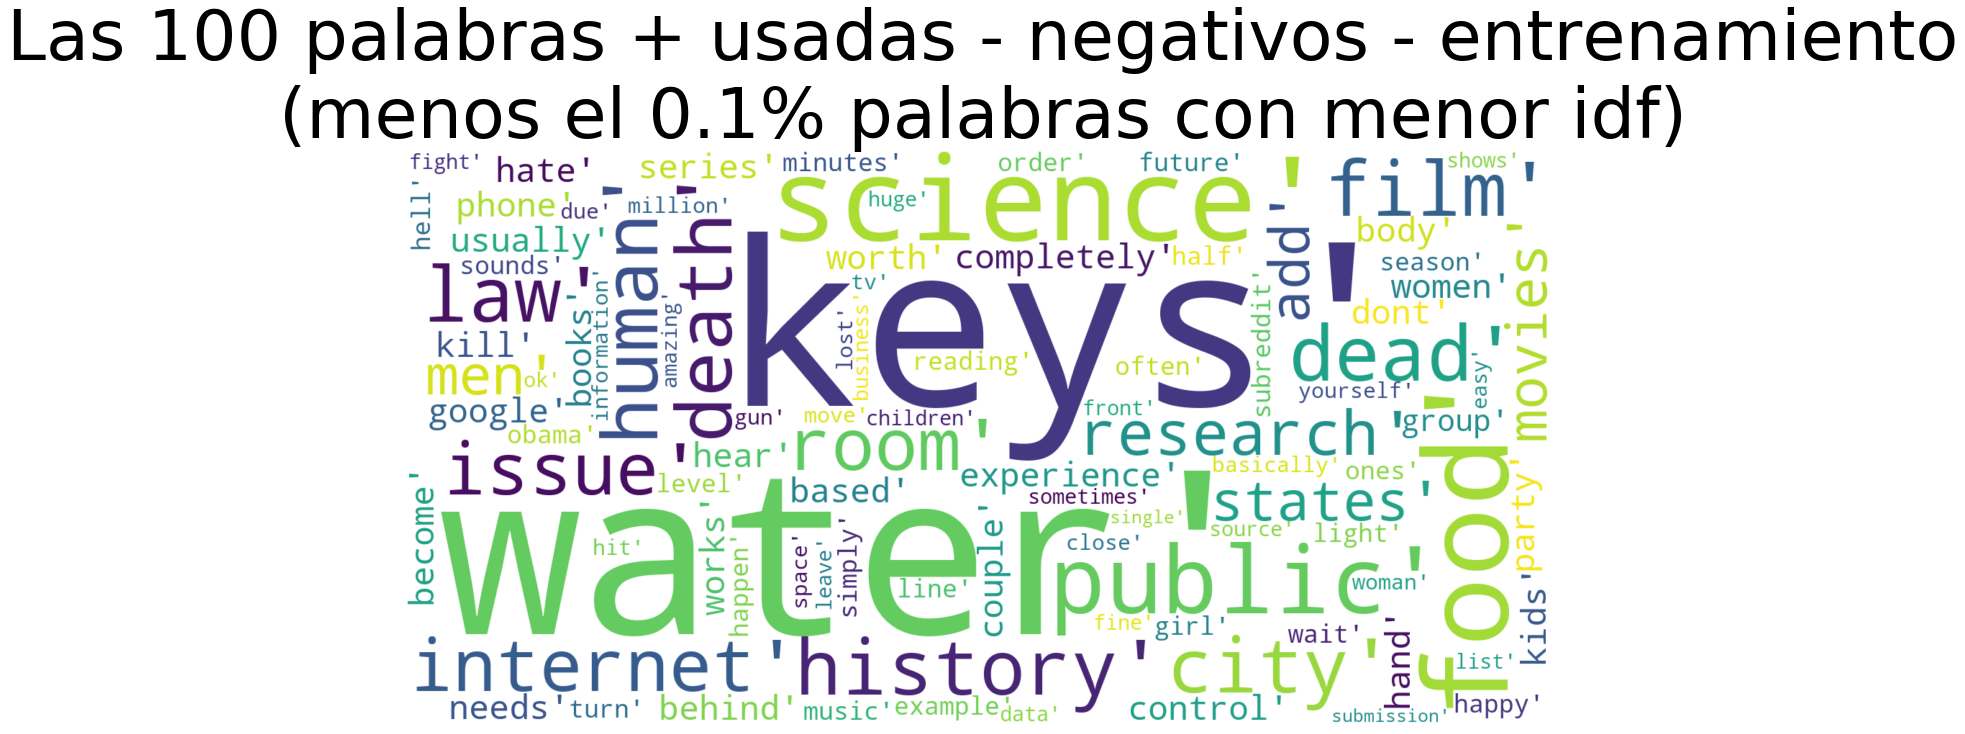

In [66]:
negative_mostcommon = FreqDist(negative_allwords).most_common(100)
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(str(negative_mostcommon))
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"Las 100 palabras + usadas - negativos - entrenamiento\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

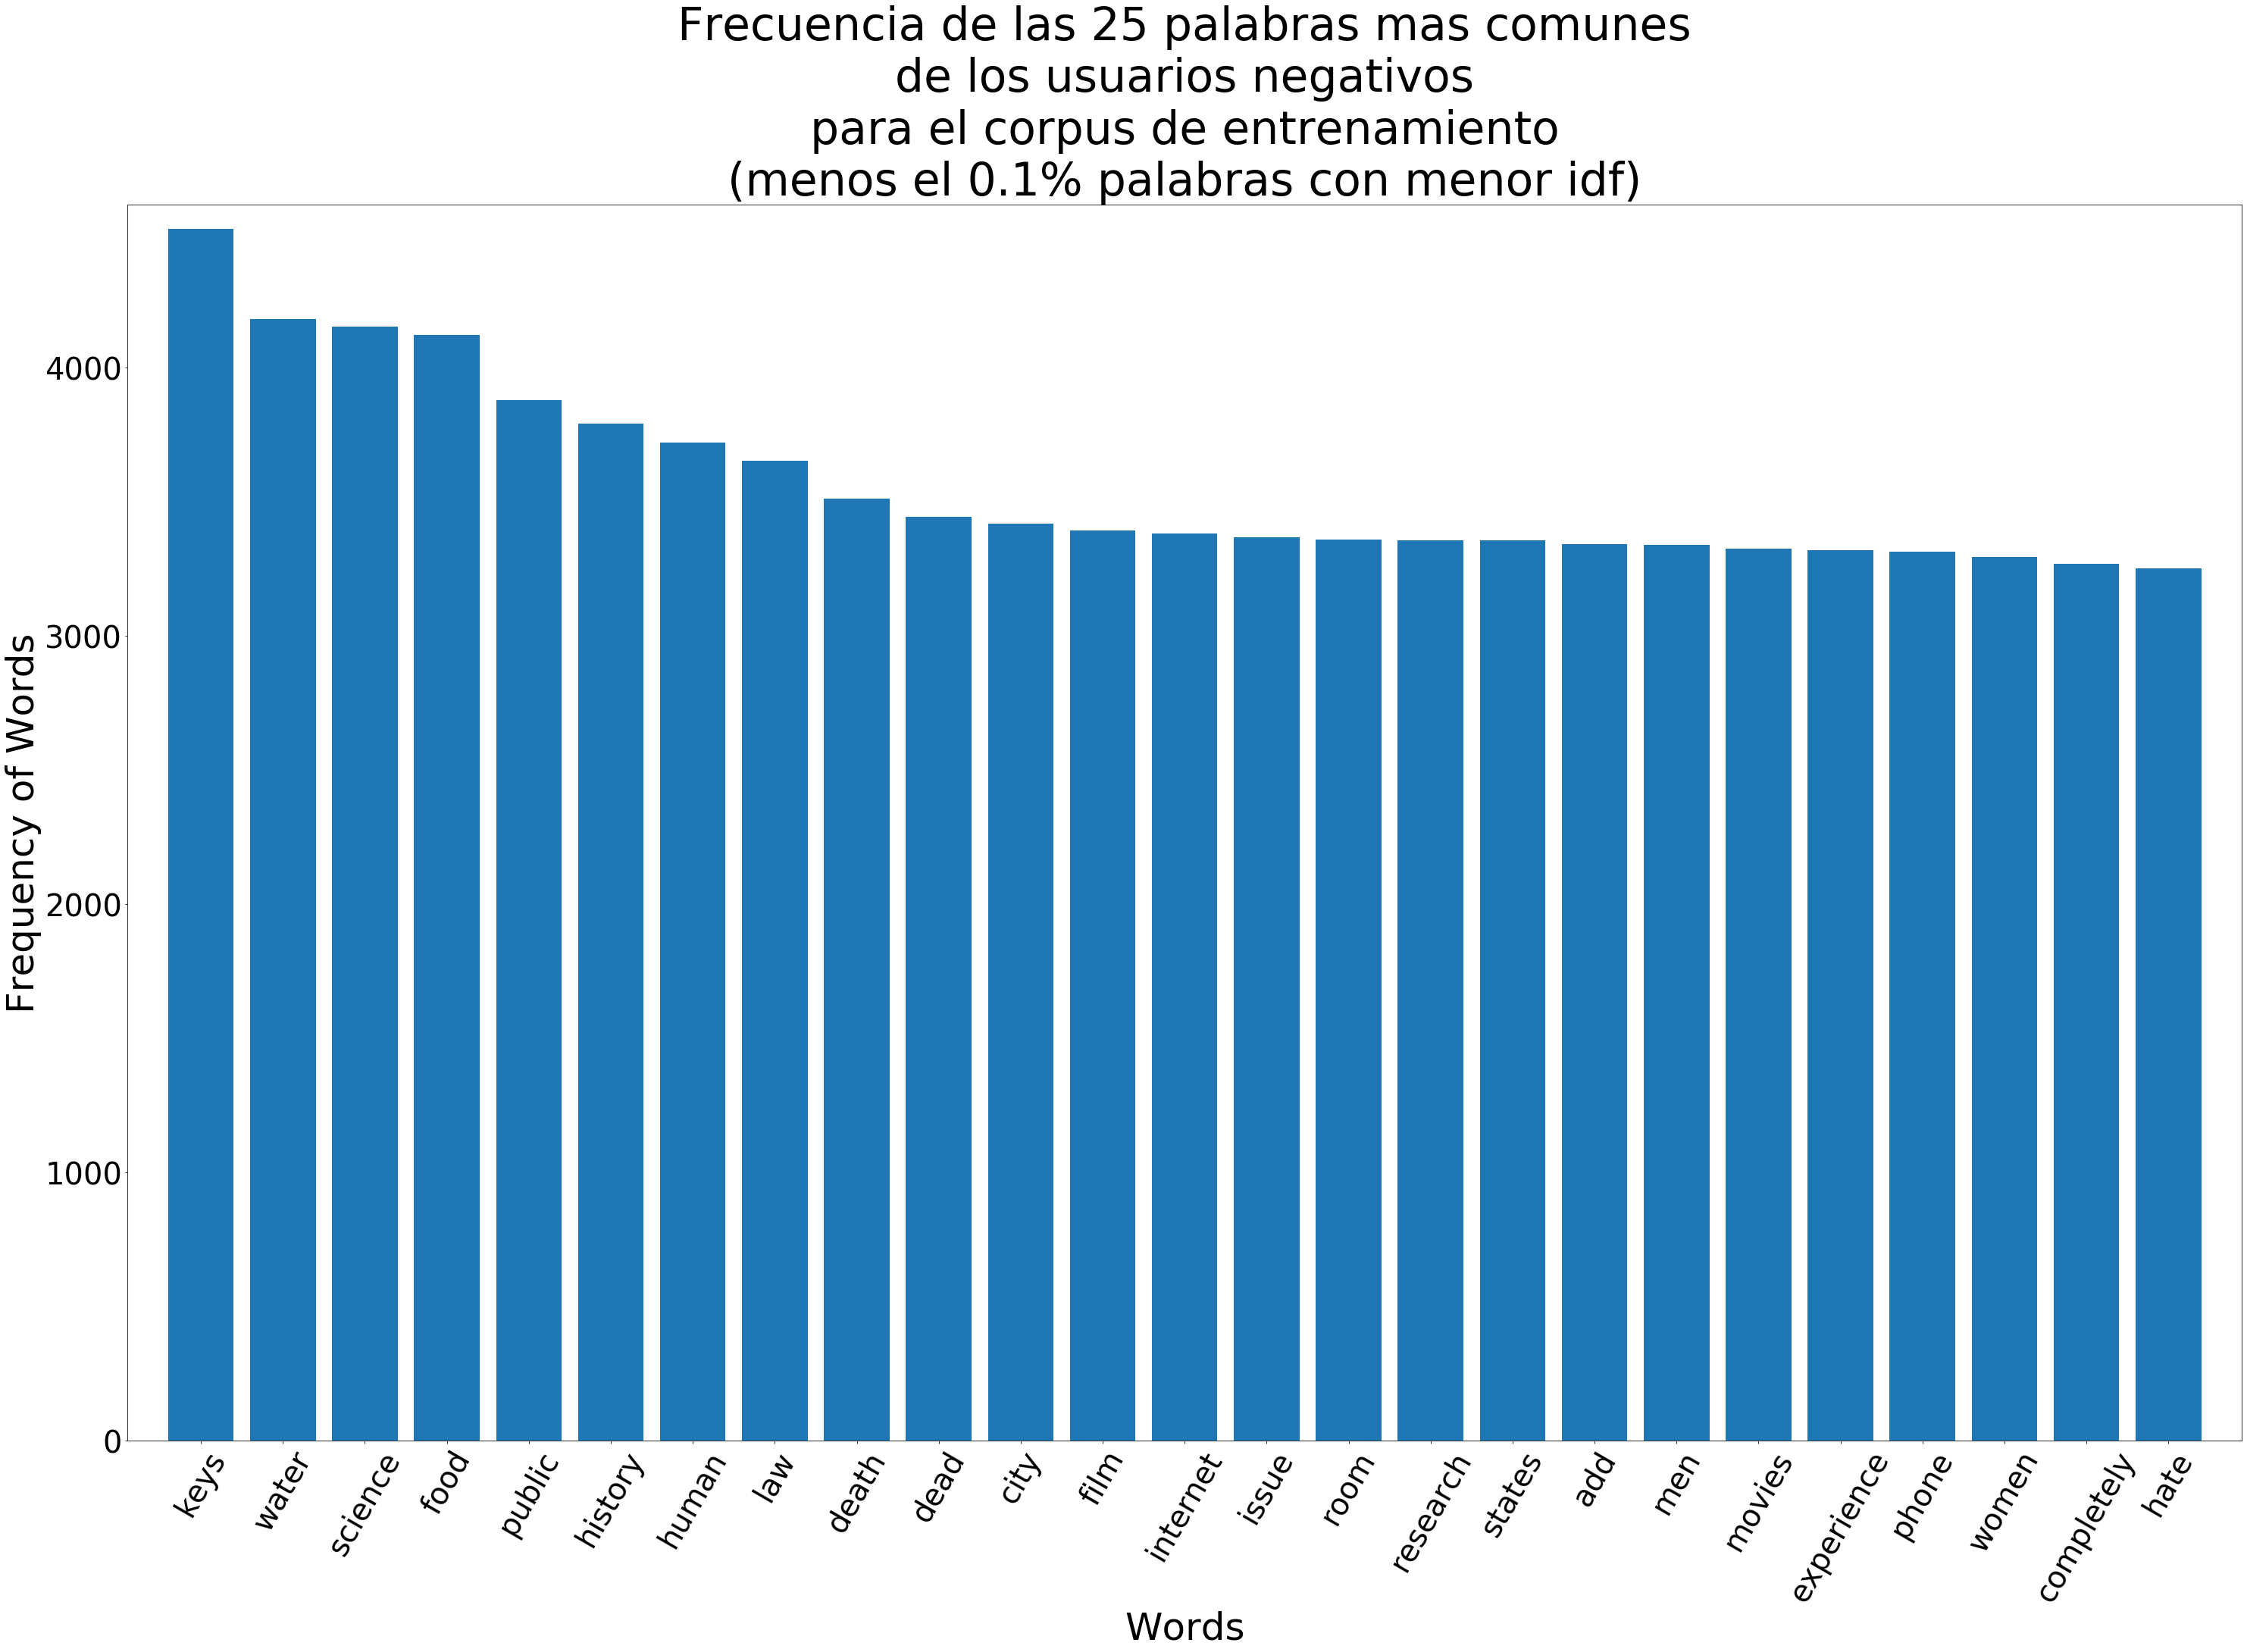

In [67]:
negative_mostcommon_small = FreqDist(negative_allwords).most_common(25)
x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    f"Frecuencia de las 25 palabras mas comunes\nde los usuarios negativos\n"
    f"para el corpus de entrenamiento\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=60,
)
plt.show()

### Dataset de Prueba

In [68]:
users_posts = df_test.posts
"""
allwords = []
for user_posts in users_posts:
    for post in user_posts:
        for word in post.split():
            if word in vectorizer.vocabulary_:
                current_idx = vectorizer.vocabulary_[word]
                if vectorizer.idf_[current_idx] > min_idf_allowed:
                    allwords.append(word)
"""
allwords = [
    word
    for user_posts in users_posts
    for post in user_posts
    for word in post.split()
    if (word in vectorizer.vocabulary_)
    and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
]

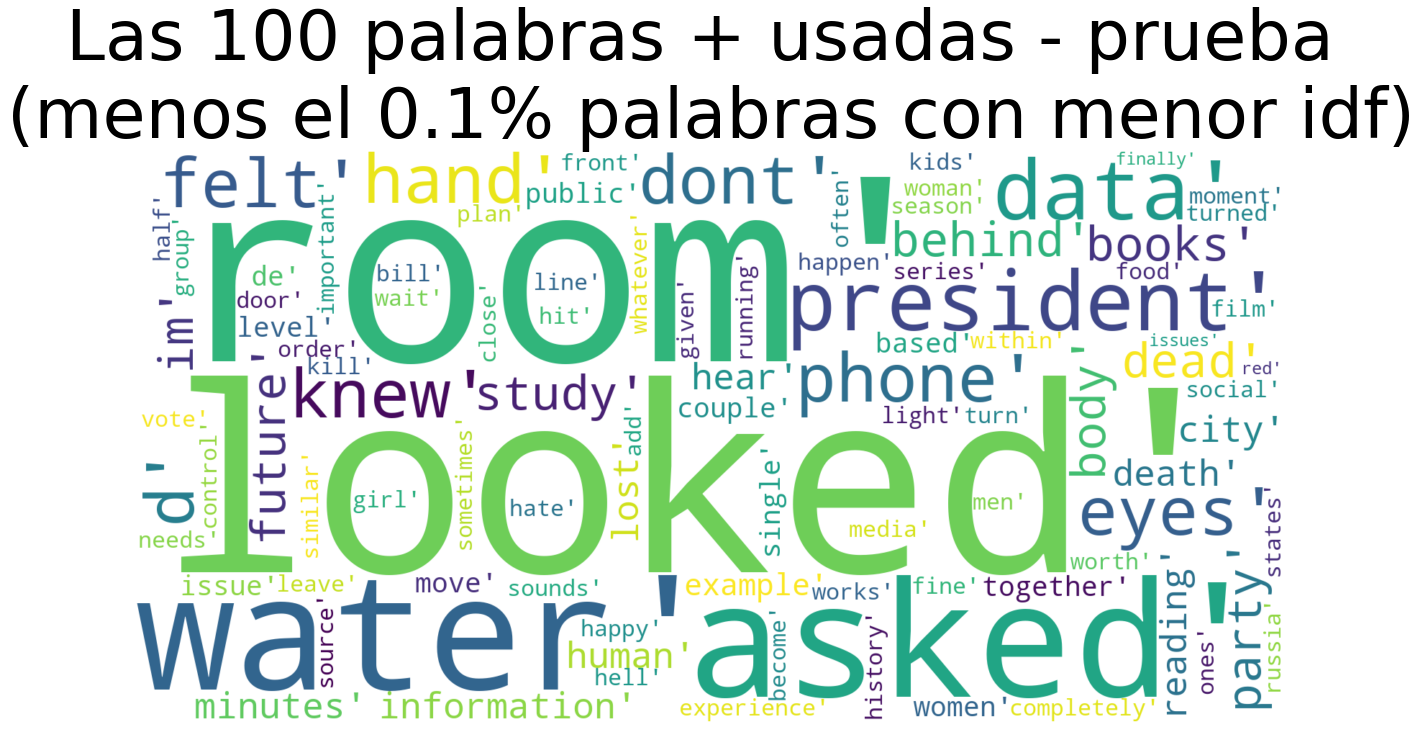

In [69]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    str(mostcommon)
)
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"Las 100 palabras + usadas - prueba \n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

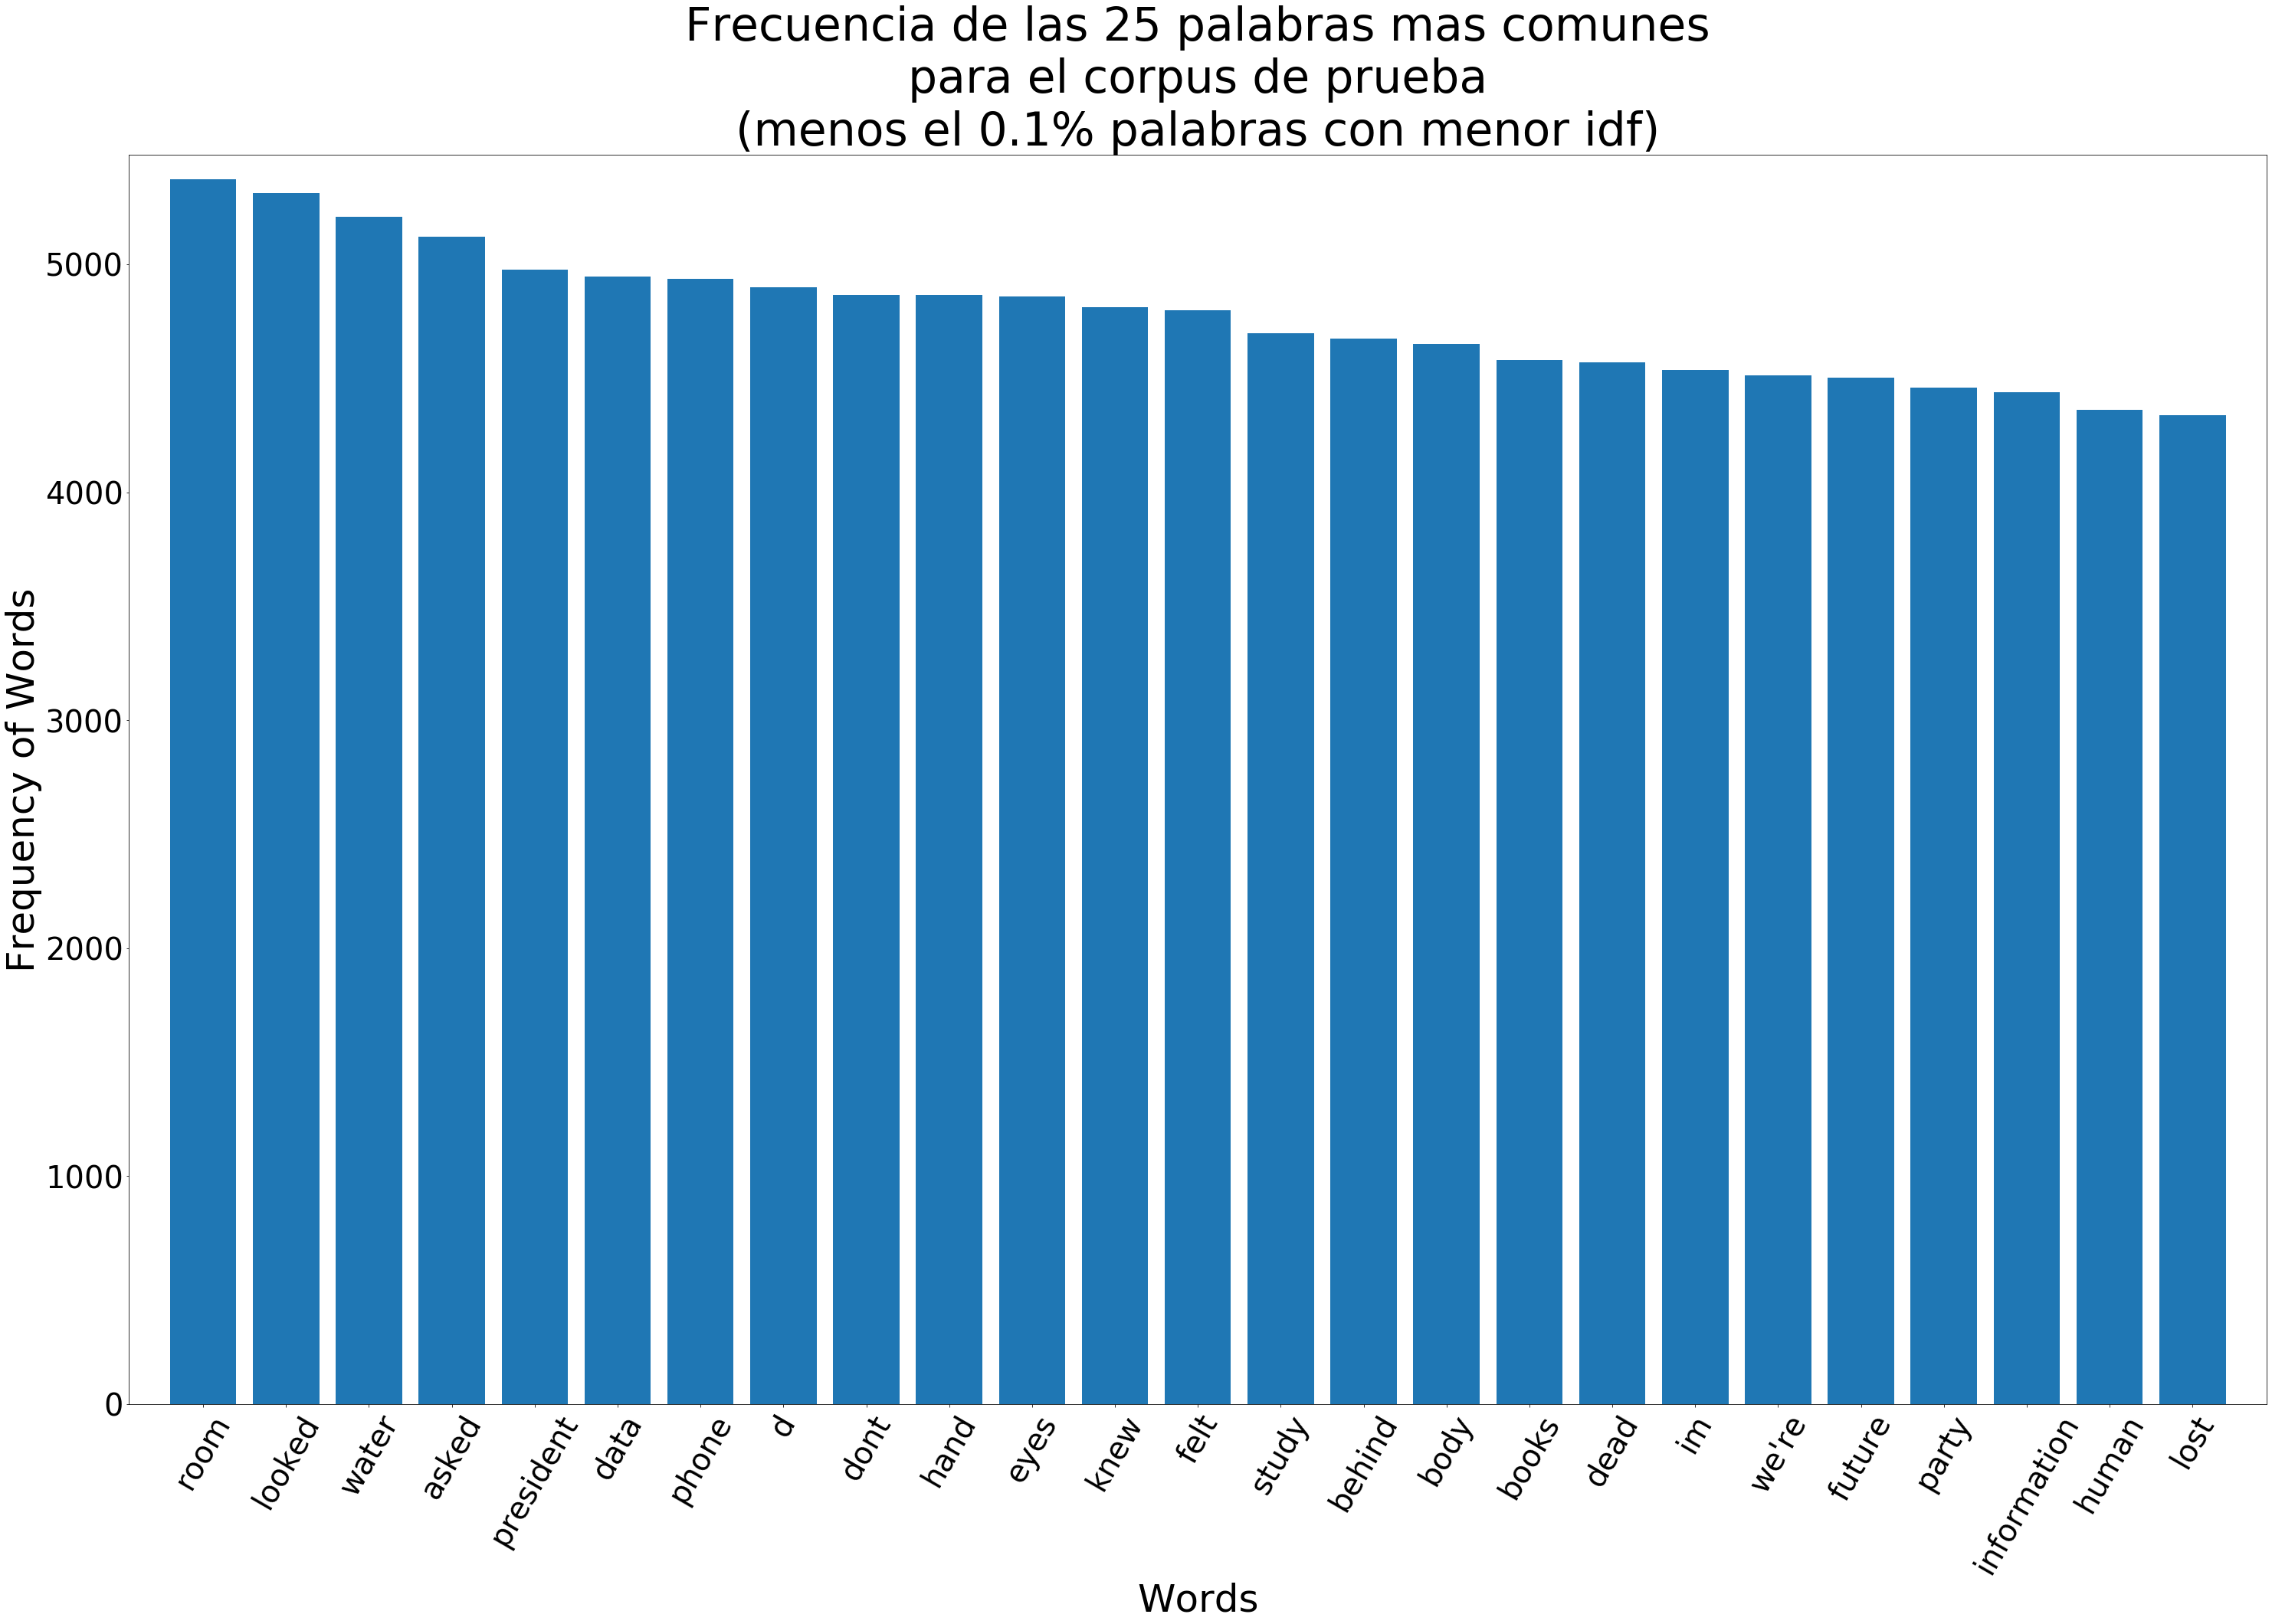

In [70]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    f"Frecuencia de las 25 palabras mas comunes\npara el corpus de prueba\n"
    f"(menos el {min_percentile}% palabras con menor idf)",
    fontsize=60,
)
plt.show()

### Nube de palabras para usuarios positivos en el corpus de prueba

In [71]:
positive_users_posts = df_test.posts[df_test.label == "positive"]
"""
positive_allwords = []
for user_posts in positive_users_posts:
    for post in user_posts:
        for word in post.split():
            if word in vectorizer.vocabulary_:
                current_idx = vectorizer.vocabulary_[word]
                if vectorizer.idf_[current_idx] > min_idf_allowed:
                    positive_allwords.append(word)
"""
positive_allwords = [
    word
    for user_posts in positive_users_posts
    for post in user_posts
    for word in post.split()
    if (word in vectorizer.vocabulary_)
    and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
]

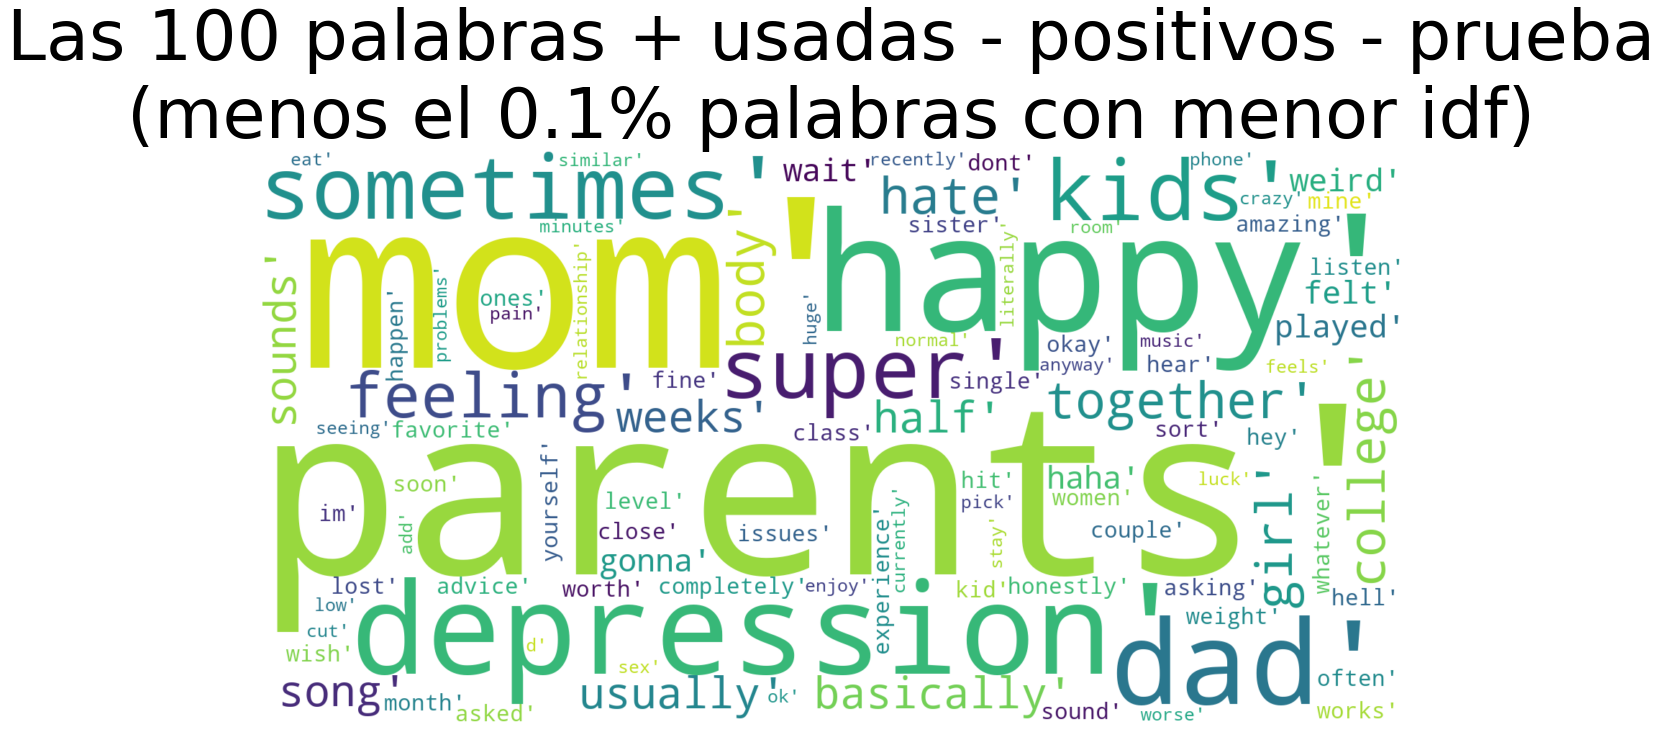

In [72]:
positive_mostcommon = FreqDist(positive_allwords).most_common(100)
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(str(positive_mostcommon))
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"Las 100 palabras + usadas - positivos - prueba\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

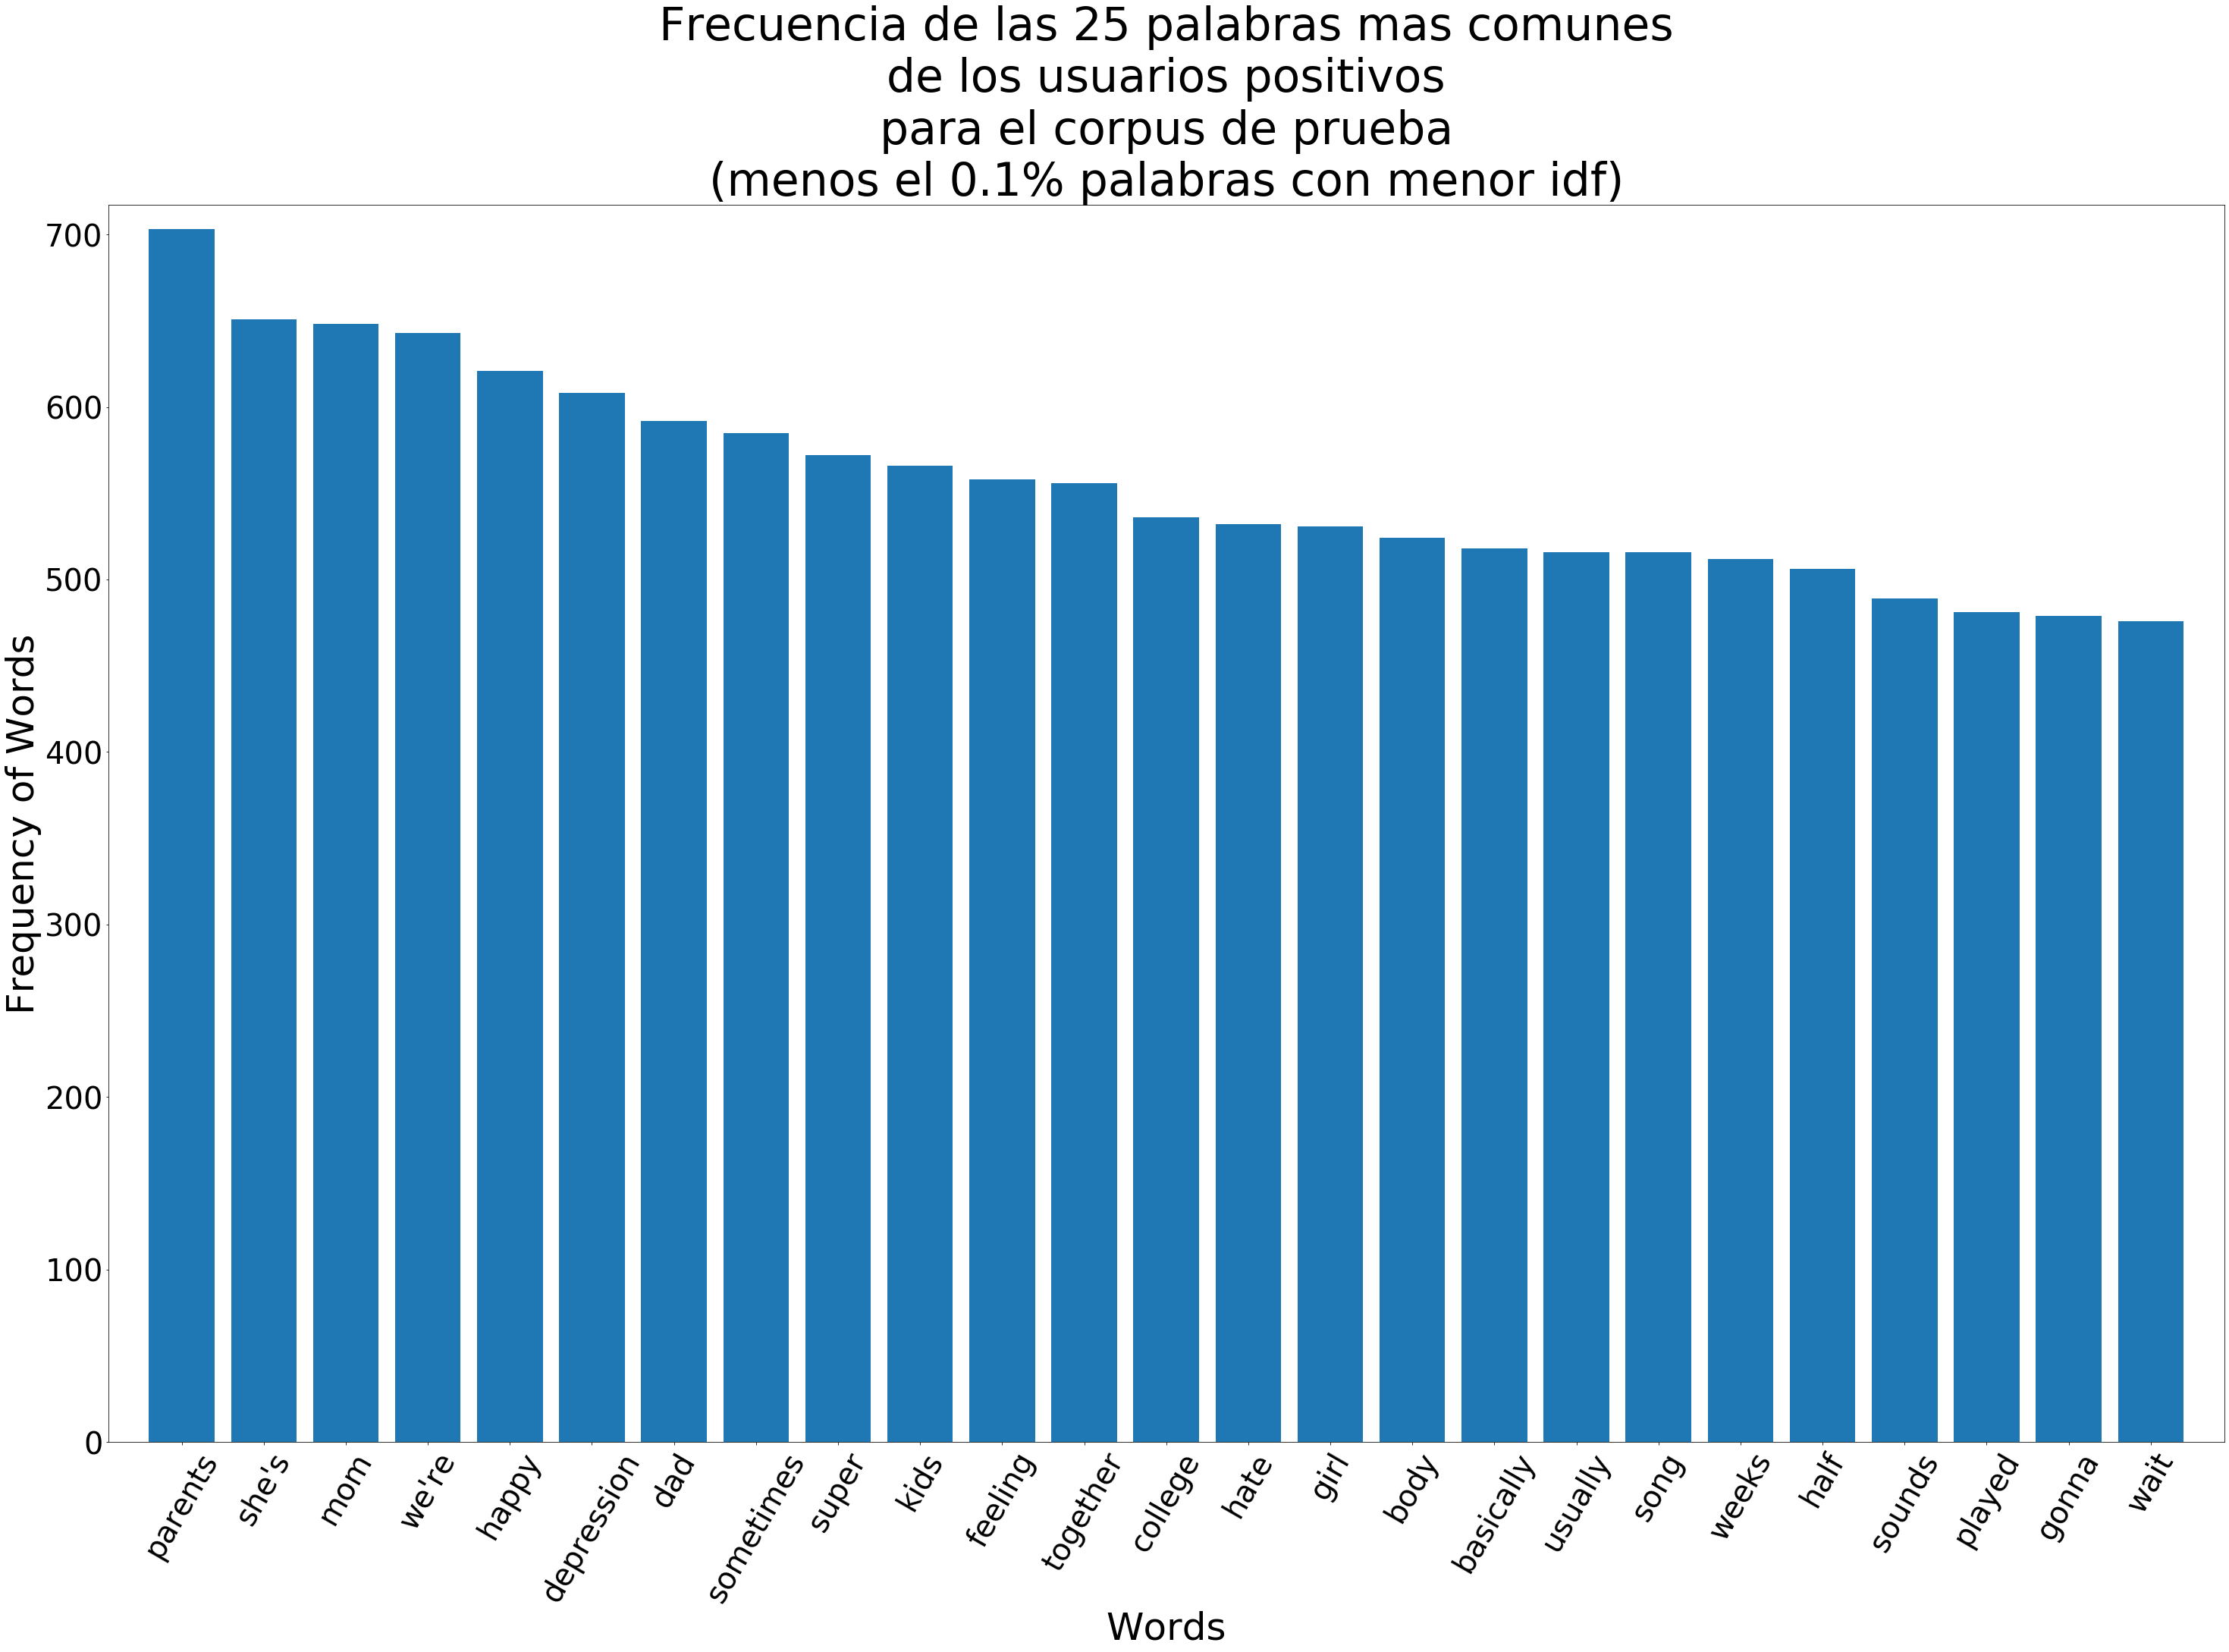

In [73]:
positive_mostcommon_small = FreqDist(positive_allwords).most_common(25)
x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    f"Frecuencia de las 25 palabras mas comunes\nde los usuarios positivos\n"
    f"para el corpus de prueba\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=60,
)
plt.show()

### Nube de palabras para usuarios negativos en el corpus de prueba

In [74]:
negative_users_posts = df_test.posts[df_test.label == "negative"]
"""
negative_allwords = []
for user_posts in negative_users_posts:
    for post in user_posts:
        for word in post.split():
            if word in vectorizer.vocabulary_:
                current_idx = vectorizer.vocabulary_[word]
                if vectorizer.idf_[current_idx] > min_idf_allowed:
                    negative_allwords.append(word)
"""
negative_allwords = [
    word
    for user_posts in negative_users_posts
    for post in user_posts
    for word in post.split()
    if (word in vectorizer.vocabulary_)
    and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
]

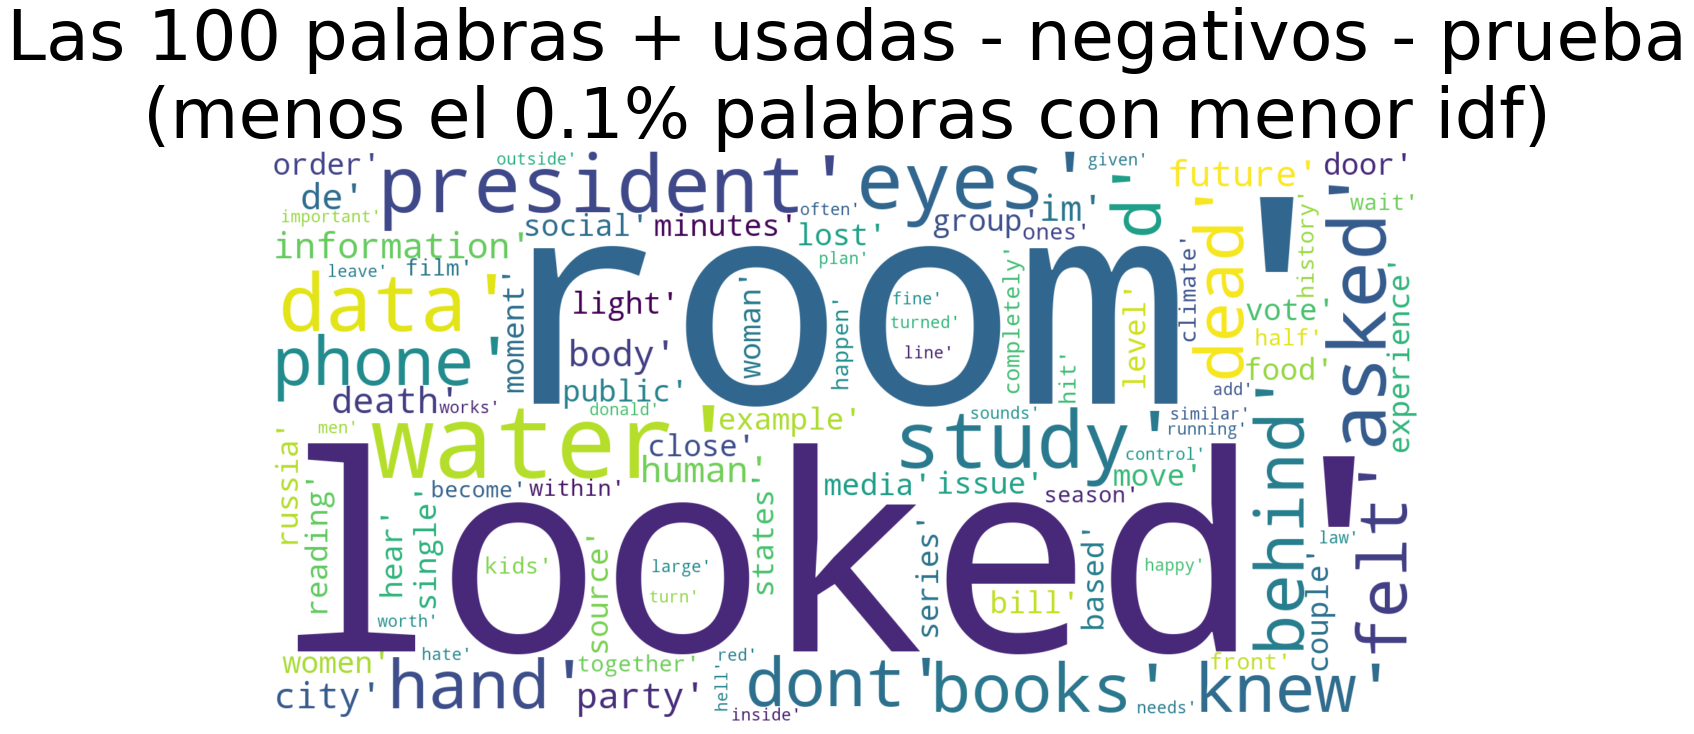

In [75]:
negative_mostcommon = FreqDist(negative_allwords).most_common(100)
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(str(negative_mostcommon))
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"Las 100 palabras + usadas - negativos - prueba\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

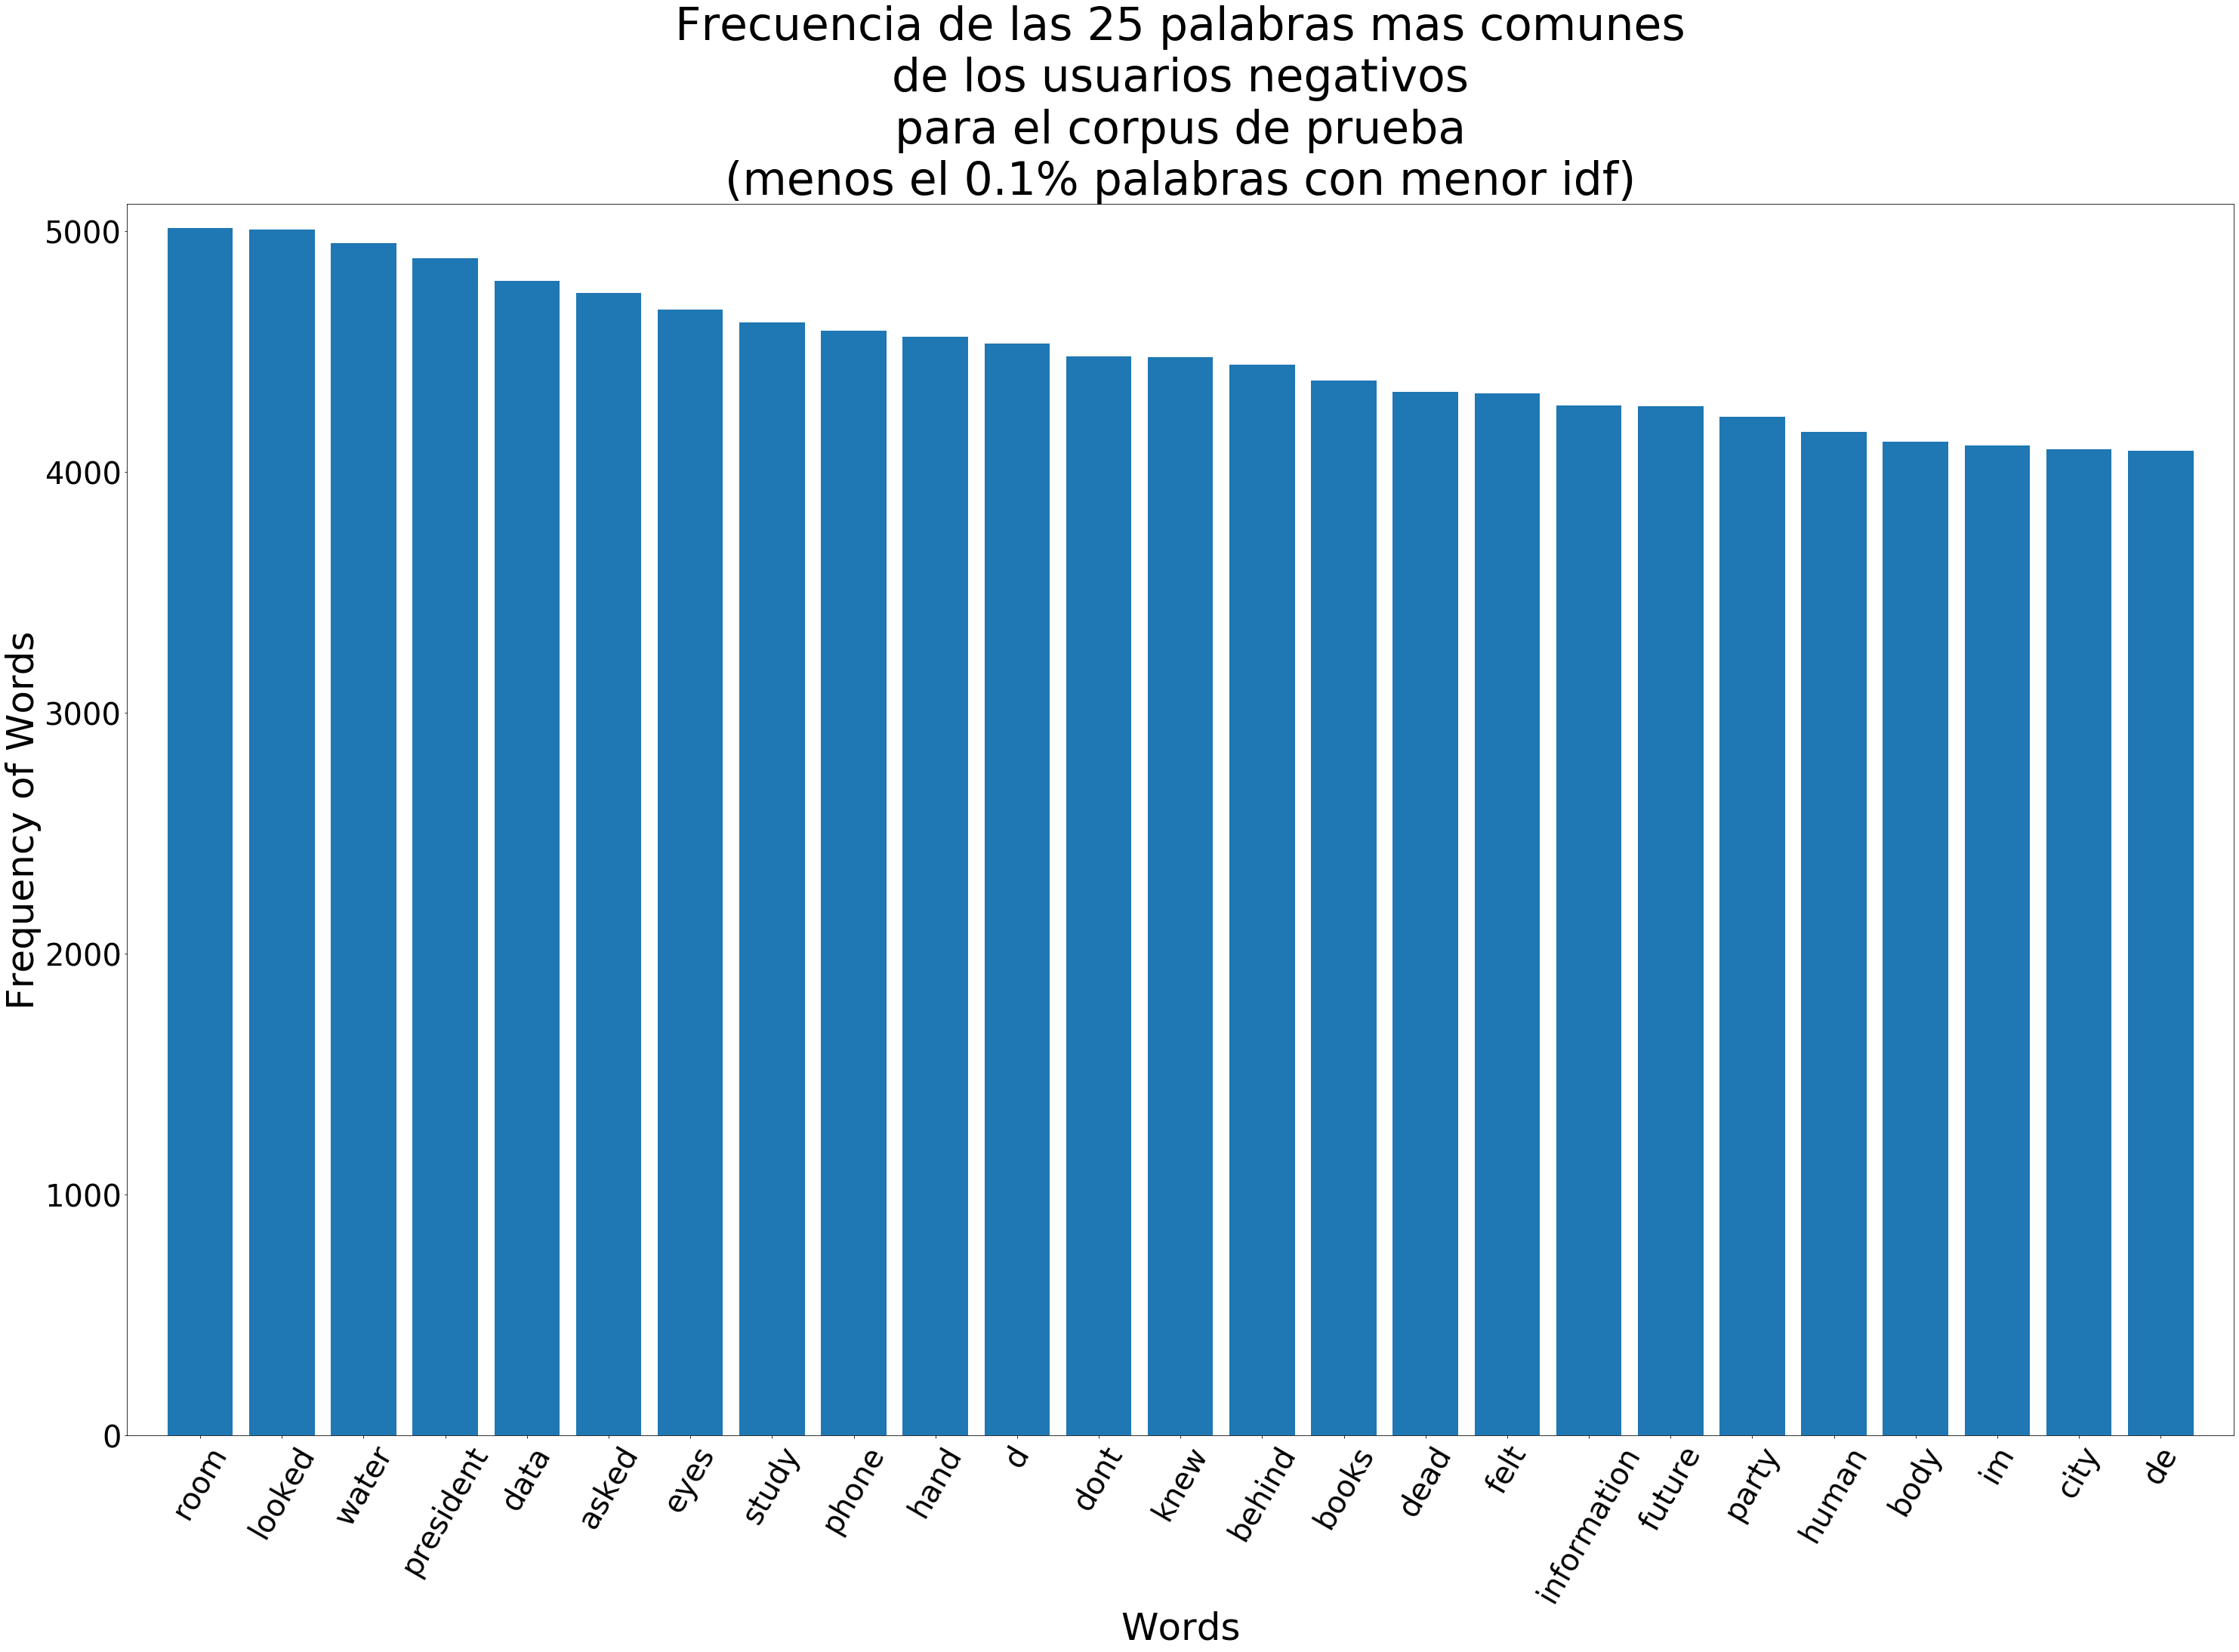

In [76]:
negative_mostcommon_small = FreqDist(negative_allwords).most_common(25)
x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    f"Frecuencia de las 25 palabras mas comunes\nde los usuarios negativos\n"
    f"para el corpus de prueba\n(menos el {min_percentile}% palabras con menor idf)",
    fontsize=60,
)
plt.show()

Mirar este [link](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) para visualizacion de LDA.